In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150
import math
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb
from keras import models
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [169]:
df2 = pd.read_csv('clean_new_well_data_fixed.csv')
df = pd.read_csv('AASG_Thermed_AllTempsThicksConds.csv',low_memory=False)

In [170]:
def remove_outliers_iqr(data, column):
    # Calculation the first and third quartiles
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    
    # Calculation the IQR (Interquartile Range)
    IQR = Q3 - Q1
    
    # Defining the lower and upper bounds to identify outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Creating masks for outliers and non-outliers
    outliers_mask = (data[column] < lower_bound) | (data[column] > upper_bound)
    # Create a mask for non-outliers
    non_outliers_mask = (data[column] >= lower_bound) & (data[column] <= upper_bound)
    
    return data[non_outliers_mask].copy(), outliers_mask

df = remove_outliers_iqr(df, 'HeatFlow')[0]
df = df.reset_index(drop=True)

# Find Closest Points for Estimation with Physical Model

In [171]:
def roundup(x):
    return int(math.ceil(x / 10.0)) * 10

num_sample=10000
sampled_df2 = df2.sample(num_sample)

# Round by 10 to later compare with T1~T500
sampled_df2.depth = np.round(sampled_df2.depth,decimals=-1).astype('int')

In [172]:
sampled_df2

id  depth       temp        lat        lon    corrtemp
509169  4702500022   2940  87.055556  38.060082 -80.733279  104.219611
572930  4710300645   1270  33.683333  39.678222 -80.823766   40.001224
392488  4704301637    590  16.372222  38.098967 -82.224157   18.205283
140671  4703905307   1620  45.144444  38.364071 -81.302917   53.739777
313158  4710100065   1080  36.227778  38.490676 -80.308062   41.247964
...            ...    ...        ...        ...        ...         ...
404158  4701705638   2190  50.427778  39.275771 -80.591375   62.730411
222383  4709501474   1210  51.618944  39.374356 -80.810535   57.496152
520037  4703501366    940  29.211111  38.729769 -81.572230   33.379741
276992  4700100668   1020  25.400000  39.010401 -80.015406   30.080359
31960   4708509707   1320  27.783333  39.228950 -81.061086   34.429128

[10000 rows x 6 columns]

In [173]:
# For finding closest well from new data to old data
neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(np.transpose(np.array([df.LatDegree, df.LongDegree])))
pred_indices = neigh.kneighbors(np.transpose(np.array([sampled_df2.lat,sampled_df2.lon])),return_distance=False)

In [174]:
sampled_df2.insert(6, 'closest',pred_indices)
sampled_df2.reset_index(inplace=True)

In [175]:
sampled_df2

index          id  depth       temp        lat        lon    corrtemp  \
0     509169  4702500022   2940  87.055556  38.060082 -80.733279  104.219611   
1     572930  4710300645   1270  33.683333  39.678222 -80.823766   40.001224   
2     392488  4704301637    590  16.372222  38.098967 -82.224157   18.205283   
3     140671  4703905307   1620  45.144444  38.364071 -81.302917   53.739777   
4     313158  4710100065   1080  36.227778  38.490676 -80.308062   41.247964   
...      ...         ...    ...        ...        ...        ...         ...   
9995  404158  4701705638   2190  50.427778  39.275771 -80.591375   62.730411   
9996  222383  4709501474   1210  51.618944  39.374356 -80.810535   57.496152   
9997  520037  4703501366    940  29.211111  38.729769 -81.572230   33.379741   
9998  276992  4700100668   1020  25.400000  39.010401 -80.015406   30.080359   
9999   31960  4708509707   1320  27.783333  39.228950 -81.061086   34.429128   

      closest  
0       18080  
1       19050  
2       17737  
3       16160  
4       19001  
...       ...  
9995    16523  
9996    16386  
9997    17292  
9998    15733  
9999    18569  

[10000 rows x 8 columns]

In [176]:
# Finding corresponding physical model temperature (T-X) from old data relevant to a given depth.
# Wells from the old data are the one closest to the wells in the new data.
predicted_values_by_physics_model = []
for i in range(0, num_sample):
    curr_depth = sampled_df2.depth[i]
    curr_row = df.loc[sampled_df2.closest[i]] # obtain the row
    t_string = 'T'+str(int(curr_depth/10))
    predicted_value = curr_row[t_string]
    predicted_values_by_physics_model.append(predicted_value)

In [177]:
predicted_values_by_physics_model = np.array(predicted_values_by_physics_model)
sampled_df2.insert(8, 'physics_pred', predicted_values_by_physics_model)

In [178]:
sampled_df2

index          id  depth       temp        lat        lon    corrtemp  \
0     509169  4702500022   2940  87.055556  38.060082 -80.733279  104.219611   
1     572930  4710300645   1270  33.683333  39.678222 -80.823766   40.001224   
2     392488  4704301637    590  16.372222  38.098967 -82.224157   18.205283   
3     140671  4703905307   1620  45.144444  38.364071 -81.302917   53.739777   
4     313158  4710100065   1080  36.227778  38.490676 -80.308062   41.247964   
...      ...         ...    ...        ...        ...        ...         ...   
9995  404158  4701705638   2190  50.427778  39.275771 -80.591375   62.730411   
9996  222383  4709501474   1210  51.618944  39.374356 -80.810535   57.496152   
9997  520037  4703501366    940  29.211111  38.729769 -81.572230   33.379741   
9998  276992  4700100668   1020  25.400000  39.010401 -80.015406   30.080359   
9999   31960  4708509707   1320  27.783333  39.228950 -81.061086   34.429128   

      closest  physics_pred  
0       18080         69.19  
1       19050         35.63  
2       17737         31.22  
3       16160         32.73  
4       19001         47.76  
...       ...           ...  
9995    16523         64.68  
9996    16386         33.71  
9997    17292         37.03  
9998    15733         30.77  
9999    18569         40.23  

[10000 rows x 9 columns]

# Add Geological Information

In [179]:
# Read optimal values
f = open("optim_result.out", "r")
lines = f.readlines()

lat_to_interpolate = sampled_df2.lat
lon_to_interpolate = sampled_df2.lon

layers = df.iloc[:,52:101].values
conds = df.iloc[:,101:150].values
mult = np.multiply(layers,conds)
np.nan_to_num(mult, 0)

optimal_neigh = []
optimal_width = []
for line in lines:
    optimal_neigh.append(line.split(',')[0][0])
    optimal_width.append(line.split(',')[1])
optimal_neigh = np.array(optimal_neigh).astype('int')
optimal_width = np.array(optimal_width).astype('float')

# Predict 49 layers information for each sampled_df2 lat and lon
predicted_mults = []
for i in range(0,49):
    def gaussian_kernel(distances):
                kernel_width = optimal_width[i]
                weights = np.exp(-(distances**2)/kernel_width)
                return weights
    knn = KNeighborsRegressor(n_neighbors=optimal_neigh[i],weights=gaussian_kernel)
    #knn = KNeighborsRegressor(n_neighbors=1,weights=gaussian_kernel)
    knn.fit(np.transpose(np.array([df.LatDegree, df.LongDegree])), mult[:,i])
    y_pred = knn.predict(np.transpose(np.array([sampled_df2.lat, sampled_df2.lon])))
    predicted_mults.append(y_pred)
    
predicted_mults = np.transpose(np.array(predicted_mults))

# Predict T_SURF
def gaussian_kernel(distances):
            kernel_width = 2.598
            weights = np.exp(-(distances**2)/kernel_width)
            return weights
knn = KNeighborsRegressor(n_neighbors=1,weights=gaussian_kernel)
knn.fit(np.transpose(np.array([df.LatDegree, df.LongDegree])), df.SurfTemp)
predicted_tsurf = knn.predict(np.transpose(np.array([sampled_df2.lat, sampled_df2.lon])))

# LightGBM Predictions

In [180]:
X_train = np.transpose(np.array([df.LatDegree,
                                df.LongDegree,
                                df.MeasureDepth_m,
                                df.SurfTemp]))
y_train = df.CorrBHT.values
X_train = np.concatenate((X_train, mult),axis=1)

X_test = np.transpose(np.array([sampled_df2.lat,
                               sampled_df2.lon,
                               sampled_df2.depth,
                               predicted_tsurf]))
X_test = np.concatenate((X_test, predicted_mults),axis=1)

In [181]:
model = lgb.LGBMRegressor(learning_rate=0.1, num_leaves=30,
                          n_estimators=200, max_depth=15, min_child_samples=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13062
[LightGBM] [Info] Number of data points in the train set: 19593, number of used features: 53
[LightGBM] [Info] Start training from score 37.071158


In [182]:
sampled_df2.insert(9, 'LightGBM_pred', y_pred)

In [183]:
sampled_df2

index          id  depth       temp        lat        lon    corrtemp  \
0     509169  4702500022   2940  87.055556  38.060082 -80.733279  104.219611   
1     572930  4710300645   1270  33.683333  39.678222 -80.823766   40.001224   
2     392488  4704301637    590  16.372222  38.098967 -82.224157   18.205283   
3     140671  4703905307   1620  45.144444  38.364071 -81.302917   53.739777   
4     313158  4710100065   1080  36.227778  38.490676 -80.308062   41.247964   
...      ...         ...    ...        ...        ...        ...         ...   
9995  404158  4701705638   2190  50.427778  39.275771 -80.591375   62.730411   
9996  222383  4709501474   1210  51.618944  39.374356 -80.810535   57.496152   
9997  520037  4703501366    940  29.211111  38.729769 -81.572230   33.379741   
9998  276992  4700100668   1020  25.400000  39.010401 -80.015406   30.080359   
9999   31960  4708509707   1320  27.783333  39.228950 -81.061086   34.429128   

      closest  physics_pred  LightGBM_pred  
0       18080         69.19      84.523753  
1       19050         35.63      38.096357  
2       17737         31.22      26.712820  
3       16160         32.73      52.292522  
4       19001         47.76      36.800107  
...       ...           ...            ...  
9995    16523         64.68      65.281172  
9996    16386         33.71      38.092431  
9997    17292         37.03      33.669489  
9998    15733         30.77      31.685436  
9999    18569         40.23      43.462705  

[10000 rows x 10 columns]

# DNN Predictions

In [184]:
model = Sequential()
model.add(Dense(100, input_shape=(53,)))
model.add(Dropout(0.001))

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.001))

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.001))

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.001))
    
model.add(Dense(1))
    
model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mae'])

model.fit(X_train, y_train, epochs=60, batch_size=32, verbose=1)

Epoch 1/60
613/613 [==============================] - 2s 2ms/step - loss: 661.0628 - mae: 8.9523
Epoch 2/60
613/613 [==============================] - 2s 3ms/step - loss: 64.5758 - mae: 5.1236
Epoch 3/60
613/613 [==============================] - 2s 3ms/step - loss: 40.9037 - mae: 4.4412
Epoch 4/60
613/613 [==============================] - 2s 3ms/step - loss: 38.6045 - mae: 4.3275
Epoch 5/60
613/613 [==============================] - 2s 3ms/step - loss: 36.0249 - mae: 4.2365
Epoch 6/60
613/613 [==============================] - 2s 3ms/step - loss: 36.0868 - mae: 4.2002
Epoch 7/60
613/613 [==============================] - 2s 3ms/step - loss: 33.2943 - mae: 4.0867
Epoch 8/60
613/613 [==============================] - 2s 3ms/step - loss: 31.5554 - mae: 3.9988
Epoch 9/60
613/613 [==============================] - 2s 3ms/step - loss: 28.3246 - mae: 3.8100
Epoch 10/60
613/613 [==============================] - 2s 2ms/step - loss: 28.0990 - mae: 3.7987
Epoch 11/60
613/613 [=================

In [185]:
y_pred = model.predict(X_test)

313/313 [==============================] - 1s 1ms/step


In [186]:
sampled_df2.insert(10, 'dnn_pred', y_pred)

In [187]:
sampled_df2

index          id  depth       temp        lat        lon    corrtemp  \
0     509169  4702500022   2940  87.055556  38.060082 -80.733279  104.219611   
1     572930  4710300645   1270  33.683333  39.678222 -80.823766   40.001224   
2     392488  4704301637    590  16.372222  38.098967 -82.224157   18.205283   
3     140671  4703905307   1620  45.144444  38.364071 -81.302917   53.739777   
4     313158  4710100065   1080  36.227778  38.490676 -80.308062   41.247964   
...      ...         ...    ...        ...        ...        ...         ...   
9995  404158  4701705638   2190  50.427778  39.275771 -80.591375   62.730411   
9996  222383  4709501474   1210  51.618944  39.374356 -80.810535   57.496152   
9997  520037  4703501366    940  29.211111  38.729769 -81.572230   33.379741   
9998  276992  4700100668   1020  25.400000  39.010401 -80.015406   30.080359   
9999   31960  4708509707   1320  27.783333  39.228950 -81.061086   34.429128   

      closest  physics_pred  LightGBM_pred   dnn_pred  
0       18080         69.19      84.523753  67.925041  
1       19050         35.63      38.096357  42.642155  
2       17737         31.22      26.712820  26.473049  
3       16160         32.73      52.292522  52.942574  
4       19001         47.76      36.800107  31.685356  
...       ...           ...            ...        ...  
9995    16523         64.68      65.281172  67.313187  
9996    16386         33.71      38.092431  39.758354  
9997    17292         37.03      33.669489  33.035618  
9998    15733         30.77      31.685436  35.787838  
9999    18569         40.23      43.462705  42.389202  

[10000 rows x 11 columns]

# Random Forest (RF) Prediction

In [188]:
model = RandomForestRegressor(
    n_estimators=500,
    max_depth=12,
    min_samples_split=2,
    min_samples_leaf=2  
)

# Fitting model to the training data (X_train, y_train)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=12, min_samples_leaf=2, n_estimators=500)

In [189]:
y_pred = model.predict(X_test)

In [190]:
sampled_df2.insert(11, 'RF_pred', y_pred)

In [191]:
sampled_df2

index          id  depth       temp        lat        lon    corrtemp  \
0     509169  4702500022   2940  87.055556  38.060082 -80.733279  104.219611   
1     572930  4710300645   1270  33.683333  39.678222 -80.823766   40.001224   
2     392488  4704301637    590  16.372222  38.098967 -82.224157   18.205283   
3     140671  4703905307   1620  45.144444  38.364071 -81.302917   53.739777   
4     313158  4710100065   1080  36.227778  38.490676 -80.308062   41.247964   
...      ...         ...    ...        ...        ...        ...         ...   
9995  404158  4701705638   2190  50.427778  39.275771 -80.591375   62.730411   
9996  222383  4709501474   1210  51.618944  39.374356 -80.810535   57.496152   
9997  520037  4703501366    940  29.211111  38.729769 -81.572230   33.379741   
9998  276992  4700100668   1020  25.400000  39.010401 -80.015406   30.080359   
9999   31960  4708509707   1320  27.783333  39.228950 -81.061086   34.429128   

      closest  physics_pred  LightGBM_pred   dnn_pred    RF_pred  
0       18080         69.19      84.523753  67.925041  82.276049  
1       19050         35.63      38.096357  42.642155  39.968699  
2       17737         31.22      26.712820  26.473049  25.194382  
3       16160         32.73      52.292522  52.942574  52.534180  
4       19001         47.76      36.800107  31.685356  33.467018  
...       ...           ...            ...        ...        ...  
9995    16523         64.68      65.281172  67.313187  67.856796  
9996    16386         33.71      38.092431  39.758354  38.033704  
9997    17292         37.03      33.669489  33.035618  31.879659  
9998    15733         30.77      31.685436  35.787838  33.221249  
9999    18569         40.23      43.462705  42.389202  44.396141  

[10000 rows x 12 columns]

# Compare Metrics

In [192]:
y_true = sampled_df2.corrtemp
y_phy = sampled_df2.physics_pred
y_gbm = sampled_df2.LightGBM_pred
y_rf = sampled_df2.RF_pred
y_dnn = sampled_df2.dnn_pred

In [193]:
def mae(y_true, y_model):
    return np.mean(abs(y_true-y_model))
def rmse(y_true, y_model):
    return np.sqrt(np.sum((y_true - y_model)**2)/len(y_true))

In [194]:
# print all maes (phys, gbm, rf, dnn)
print(mae(y_true, y_phy), mae(y_true, y_gbm), mae(y_true, y_rf), mae(y_true, y_dnn))

8.969809848940354 7.489365436383109 7.732739385369158 7.367344978990534


In [195]:
# print all rmses (phys, gbm, rf, dnn)
print(rmse(y_true, y_phy), rmse(y_true, y_gbm), rmse(y_true, y_rf), rmse(y_true, y_dnn))

12.62701039109847 9.571705309146717 9.765185316453563 9.593214020131835


In [196]:
# print all std (phys, gbm, rf, dnn)
print(np.std(abs(y_true-y_phy)), np.std(abs(y_true-y_gbm)), np.std(abs(y_true-y_rf)), np.std(abs(y_true-y_dnn)))

8.887288826788582 5.960448631223772 5.963521263703256 6.14426425185286


# Graphs

Text(0, 0.5, 'Prediction Value')

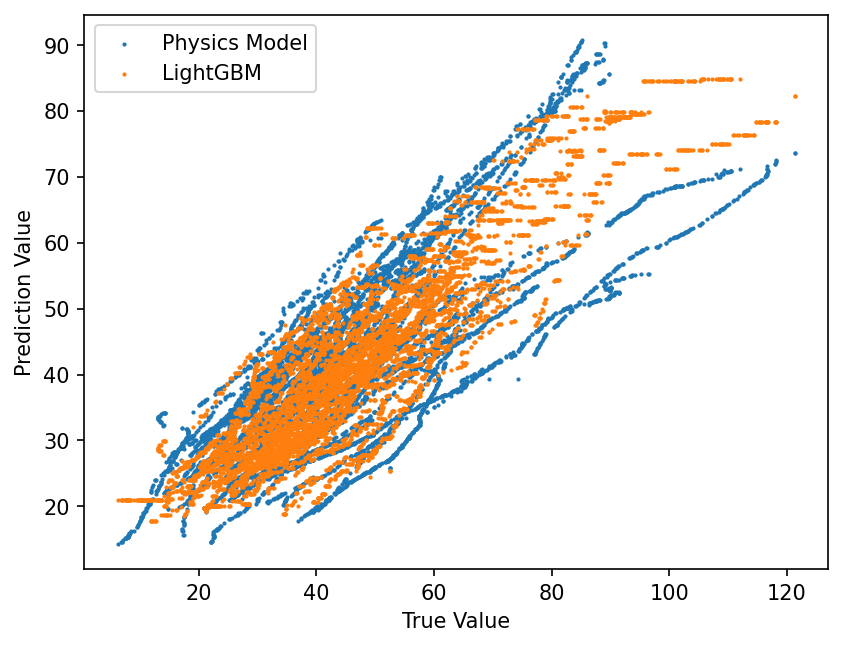

In [197]:
plt.scatter(y_true, y_phy,label='Physics Model', s=1)
plt.scatter(y_true,y_gbm, label='LightGBM', s=1)
plt.legend()
plt.xlabel('True Value')
plt.ylabel('Prediction Value')

In [198]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=1)
latlon = np.transpose(np.concatenate(([sampled_df2.lat.values],[sampled_df2.lon]),axis=0))
latlon_original=np.transpose(np.concatenate(([df.LatDegree.values],[df.LongDegree.values]),axis=0))

neigh.fit(latlon_original)
distances = neigh.kneighbors(latlon)

In [199]:
sampled_df2.insert(12, 'distance', distances[0]*110.567)

In [200]:
sampled_df2
sampled_df2['avgd_model'] = sampled_df2[['physics_pred', 'LightGBM_pred', 'dnn_pred']].mean(axis=1)

In [201]:
# Group by 'Index' column
grouped = sampled_df2.groupby('id')

# Iterate over groups and print them
for index, group in grouped:
    print("Index:", index)
    print(group)


Index: 4700100668
       index          id  depth       temp        lat        lon   corrtemp  \
30    274392  4700100668    820  20.761111  39.010401 -80.015406  24.149728   
47    278264  4700100668   1120  27.416667  39.010401 -80.015406  32.728986   
55    291592  4700100668   2140  58.561111  39.010401 -80.015406  70.495101   
87    293107  4700100668   2250  62.972222  39.010401 -80.015406  75.664862   
106   273753  4700100668    780  19.688889  39.010401 -80.015406  22.760035   
...      ...         ...    ...        ...        ...        ...        ...   
9948  292491  4700100668   2200  61.638889  39.010401 -80.015406  74.025485   
9957  275492  4700100668    910  22.838889  39.010401 -80.015406  26.774012   
9971  272238  4700100668    660  17.188889  39.010401 -80.015406  19.507347   
9982  288259  4700100668   1880  51.316667  39.010401 -80.015406  61.594742   
9998  276992  4700100668   1020  25.400000  39.010401 -80.015406  30.080359   

      closest  physics_pred  Ligh

In [202]:
unique = sampled_df2['id'].unique()

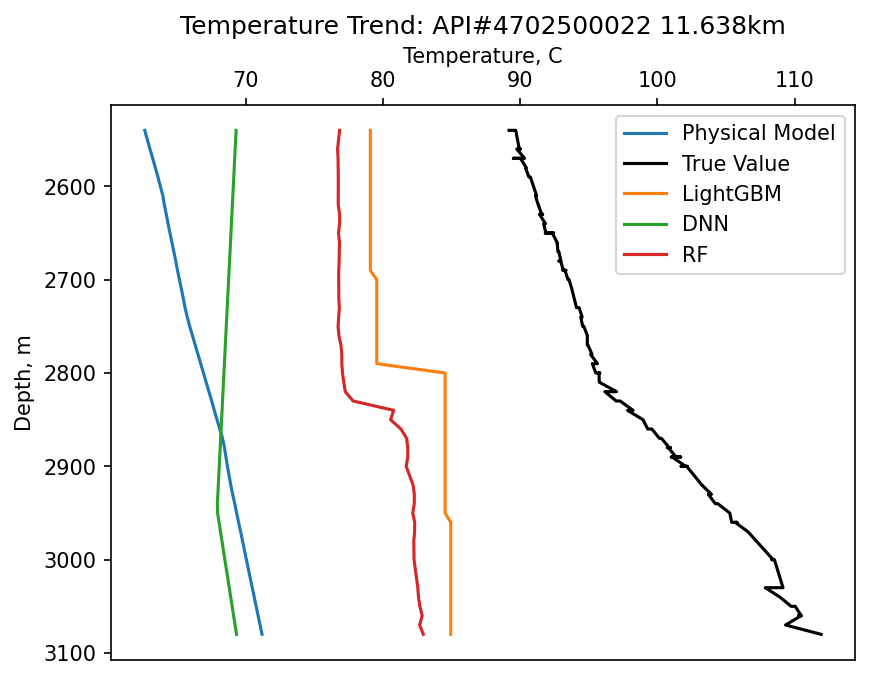

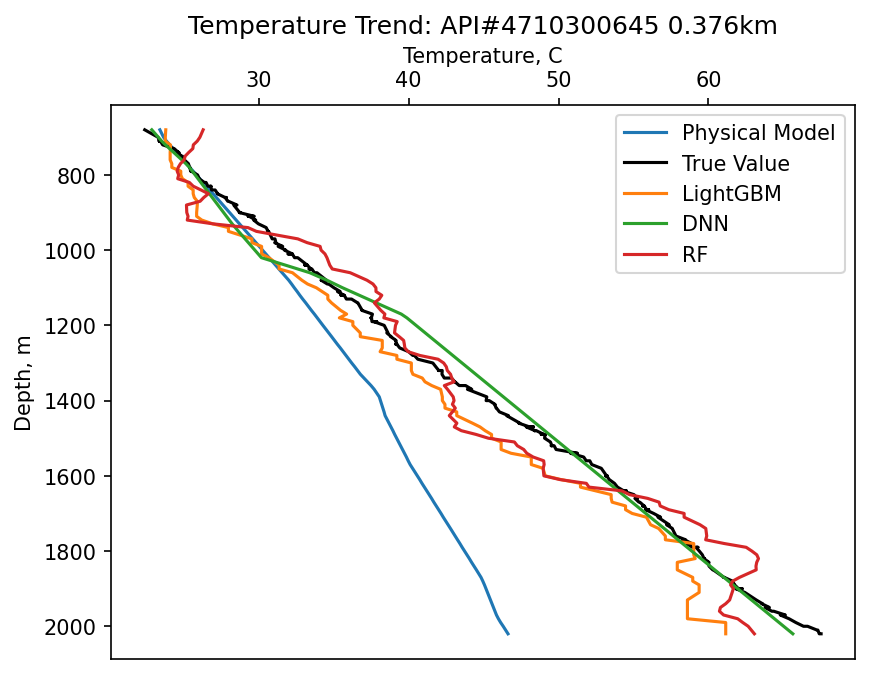

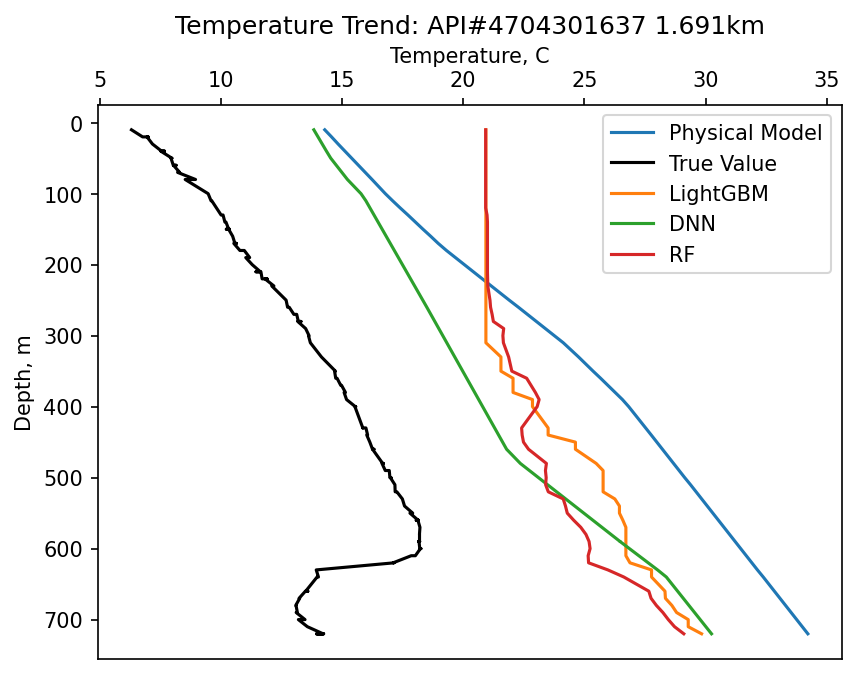

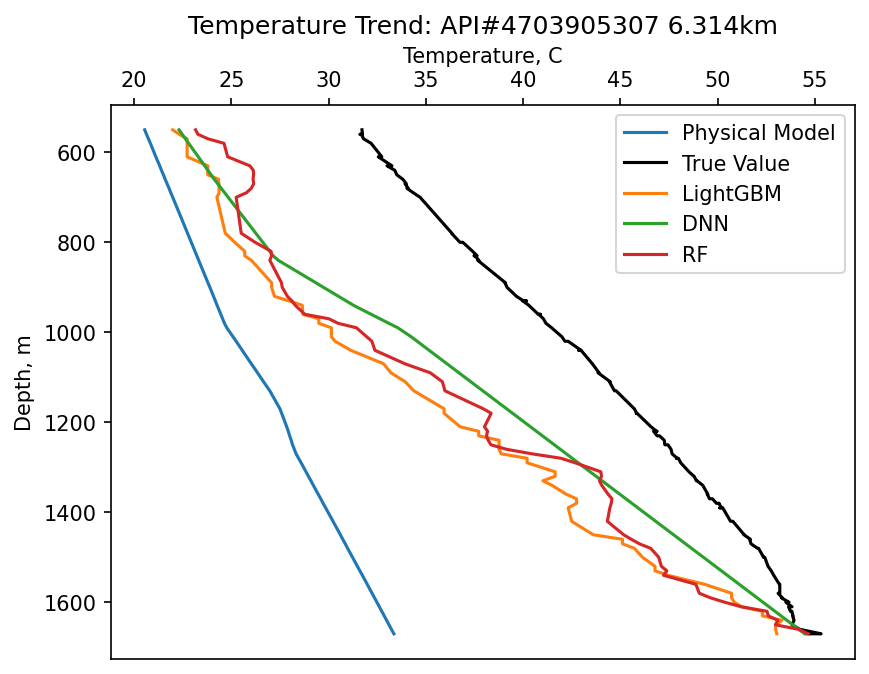

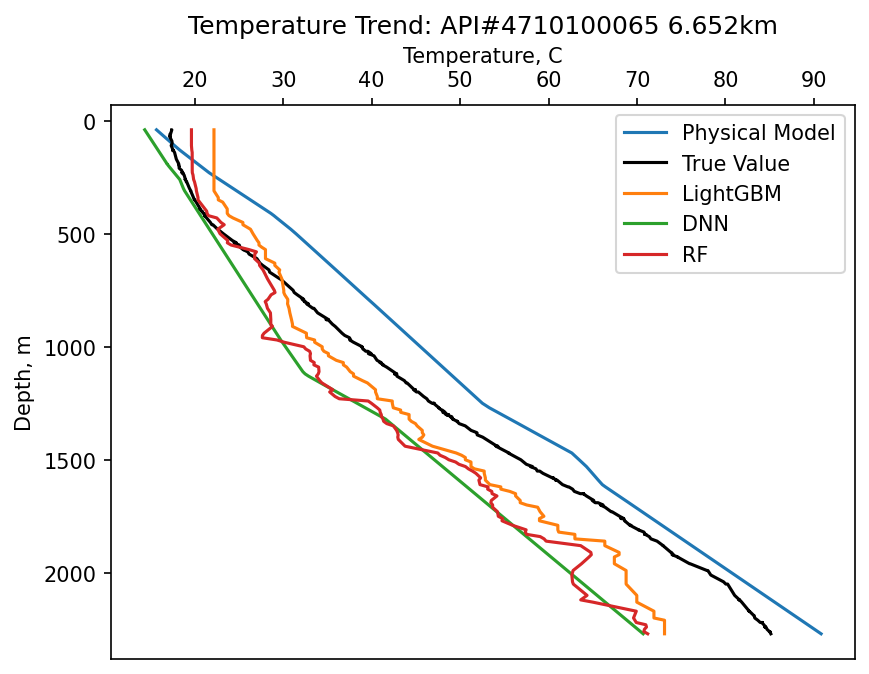

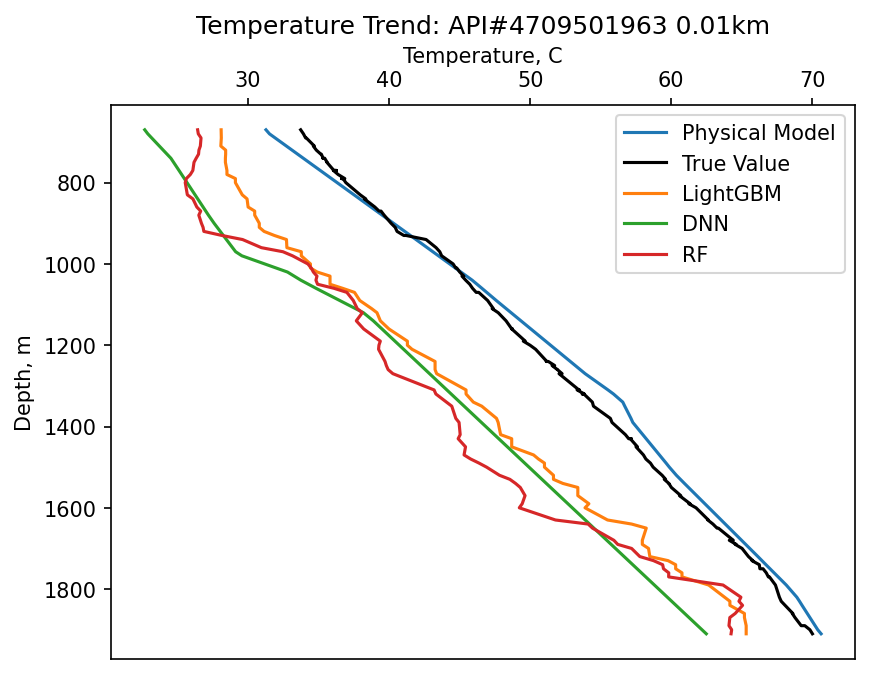

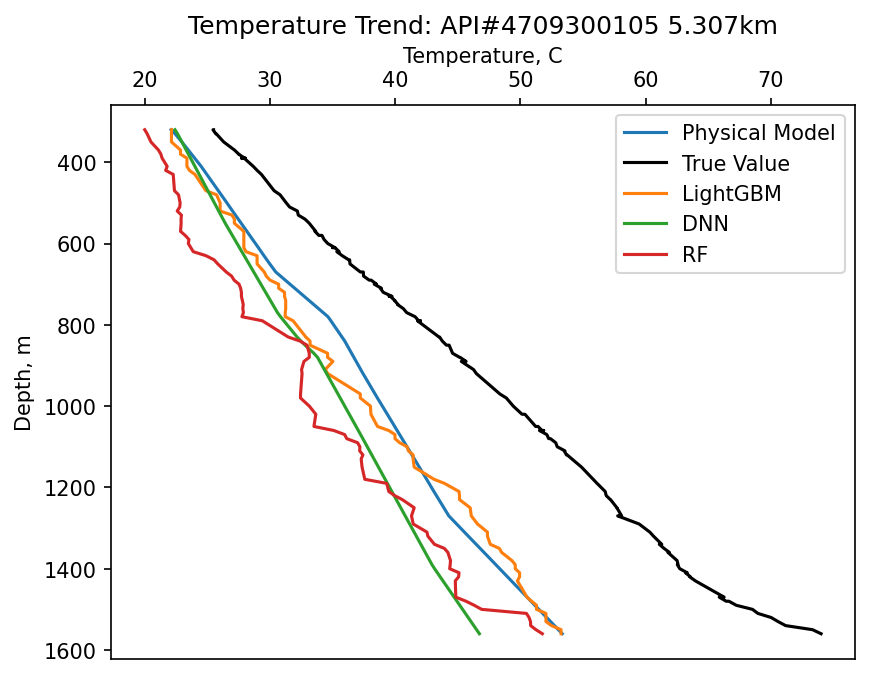

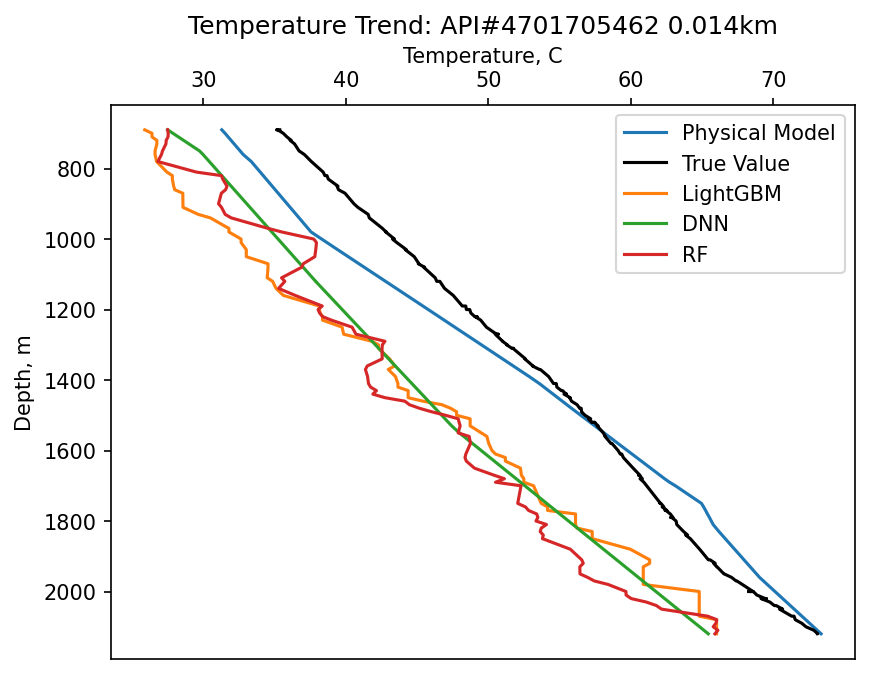

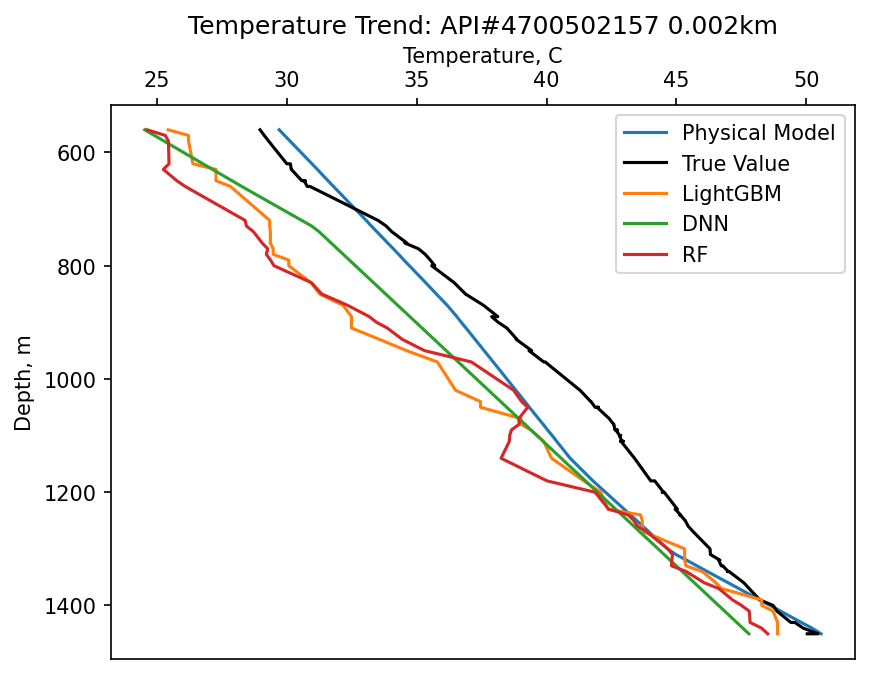

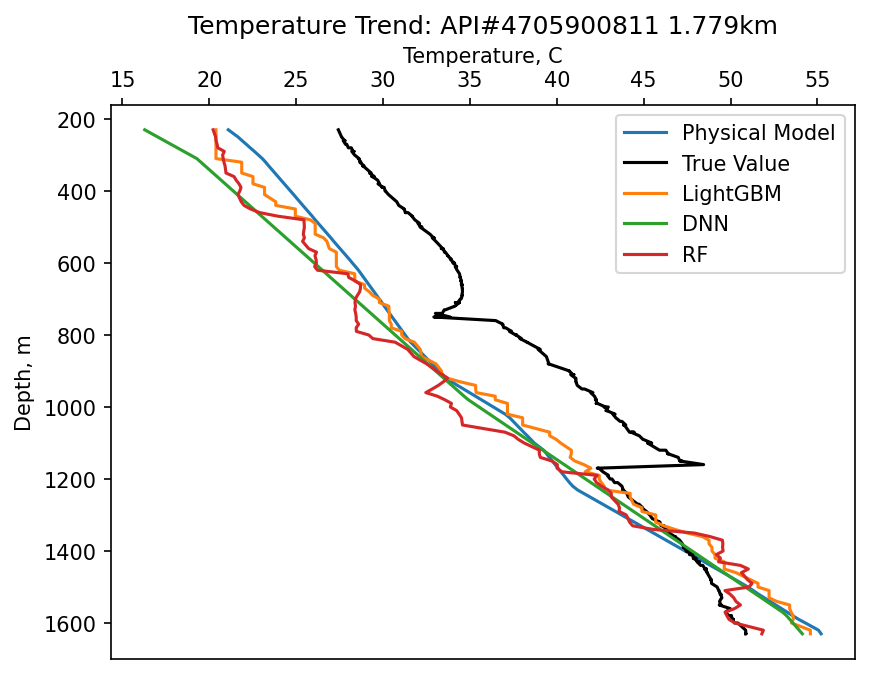

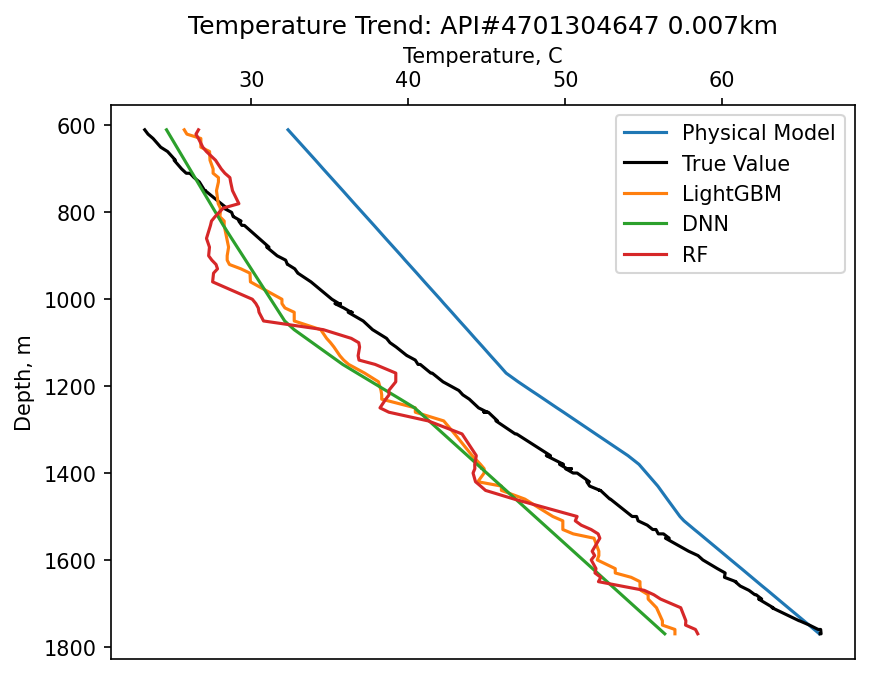

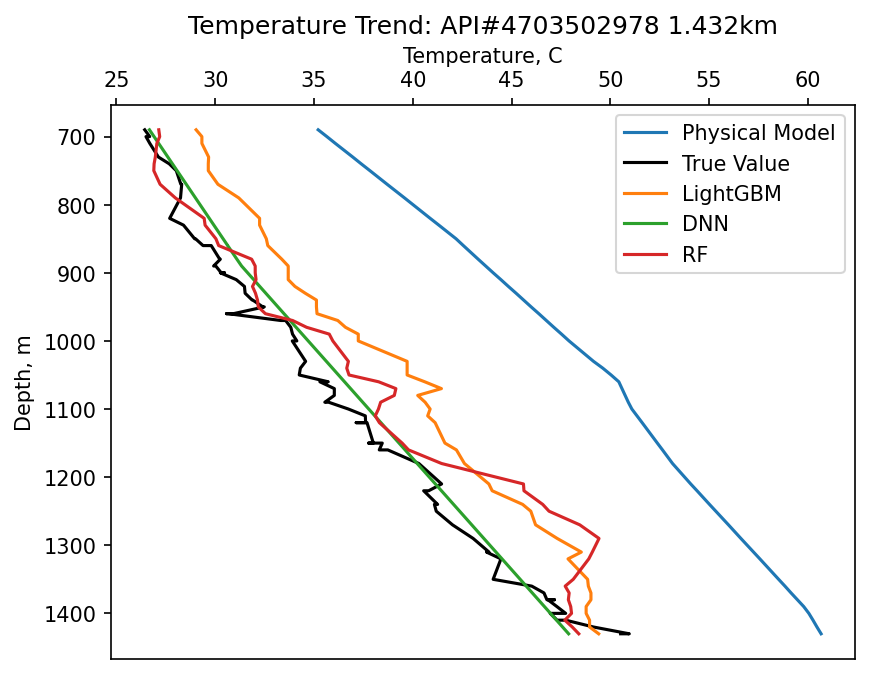

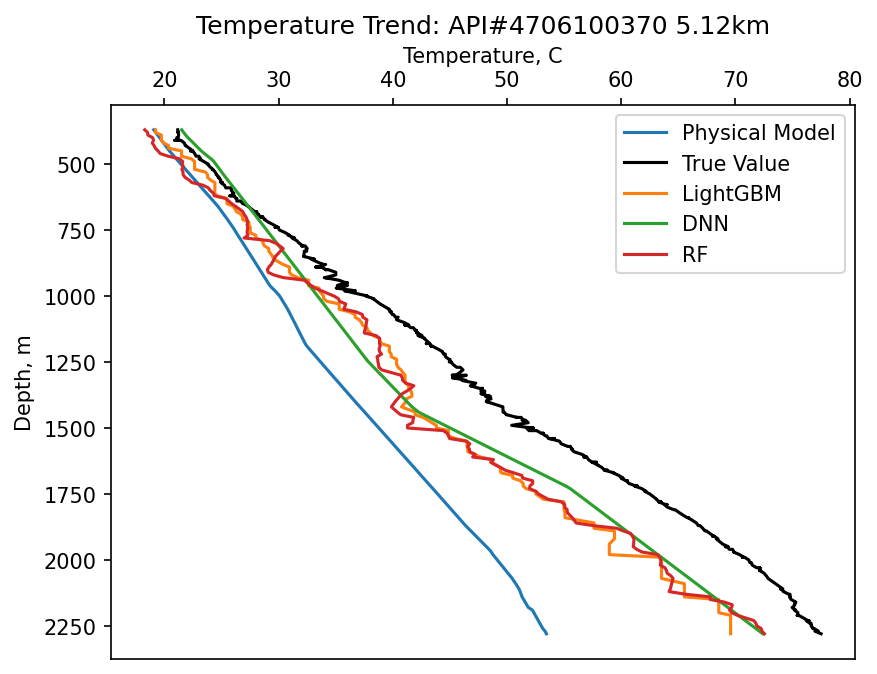

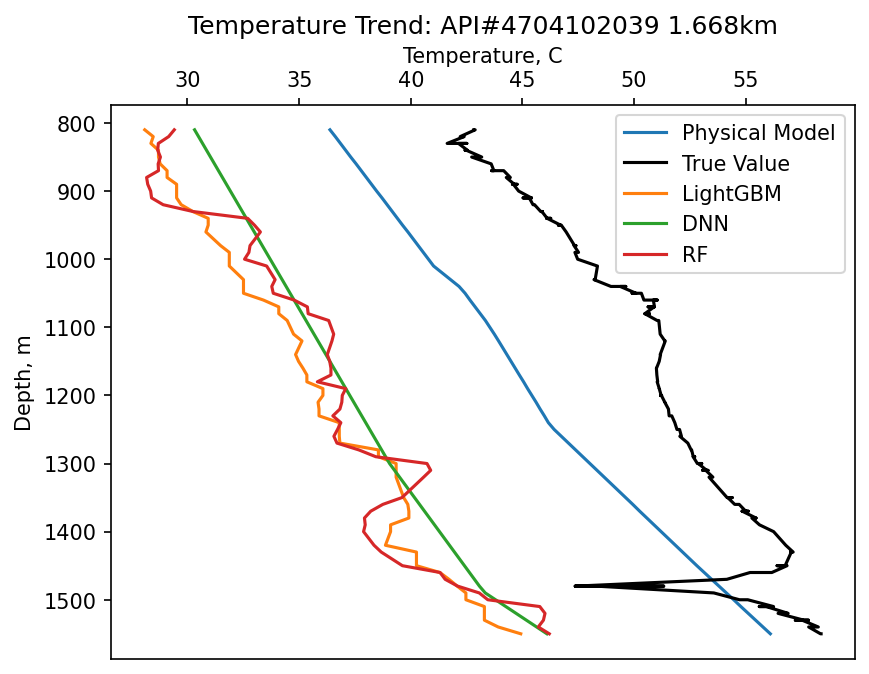

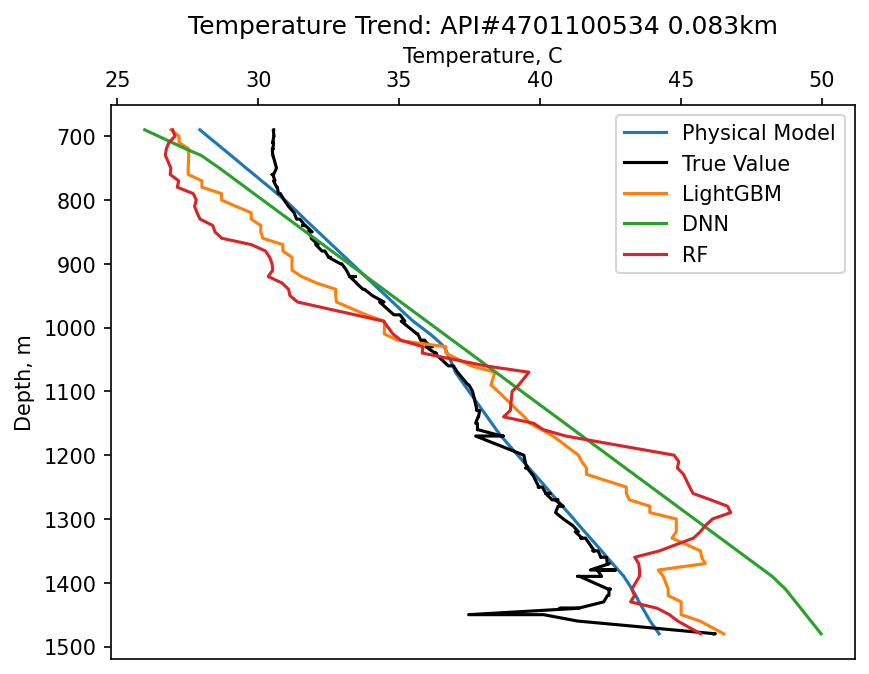

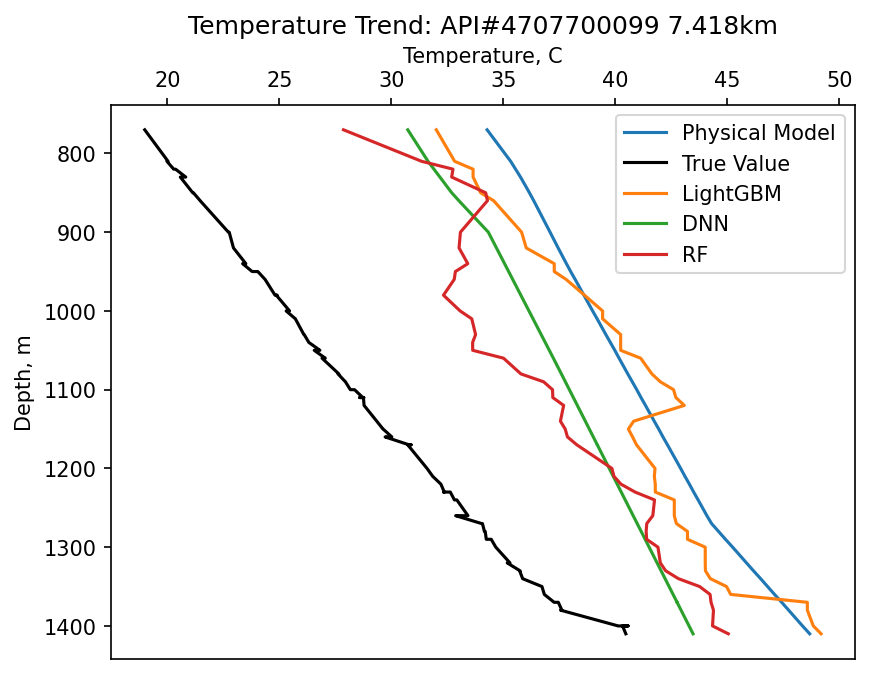

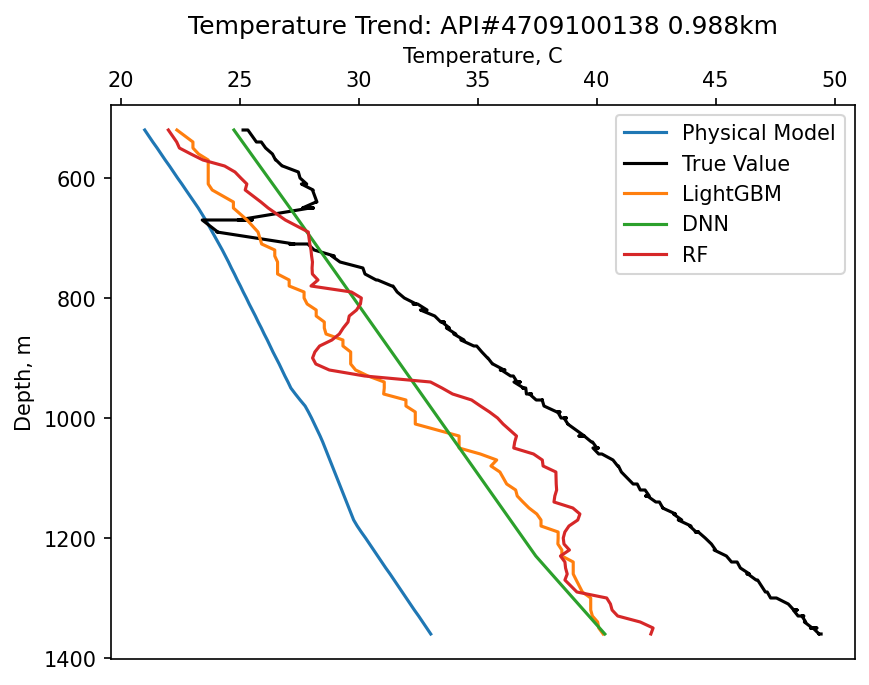

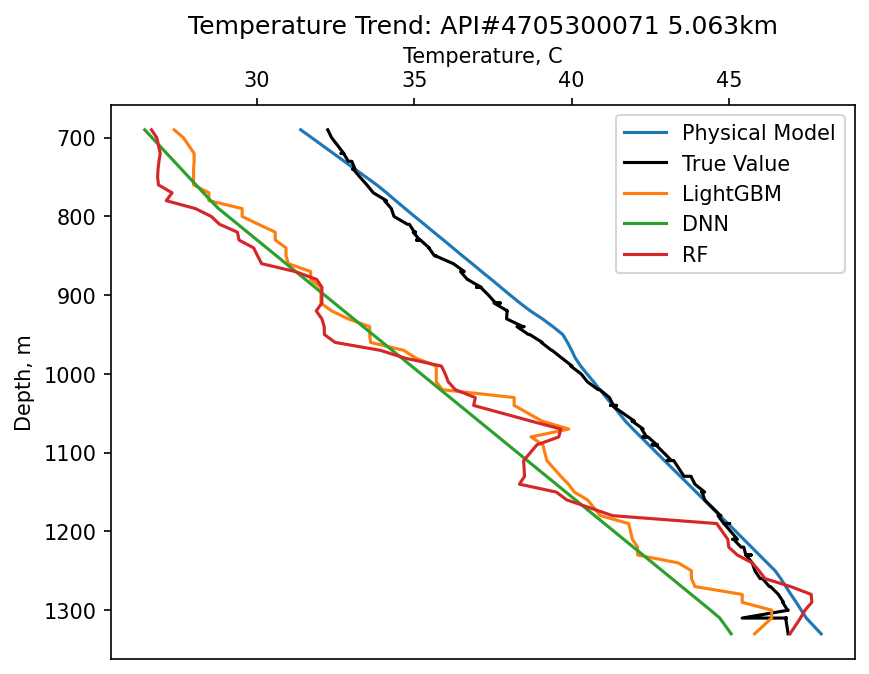

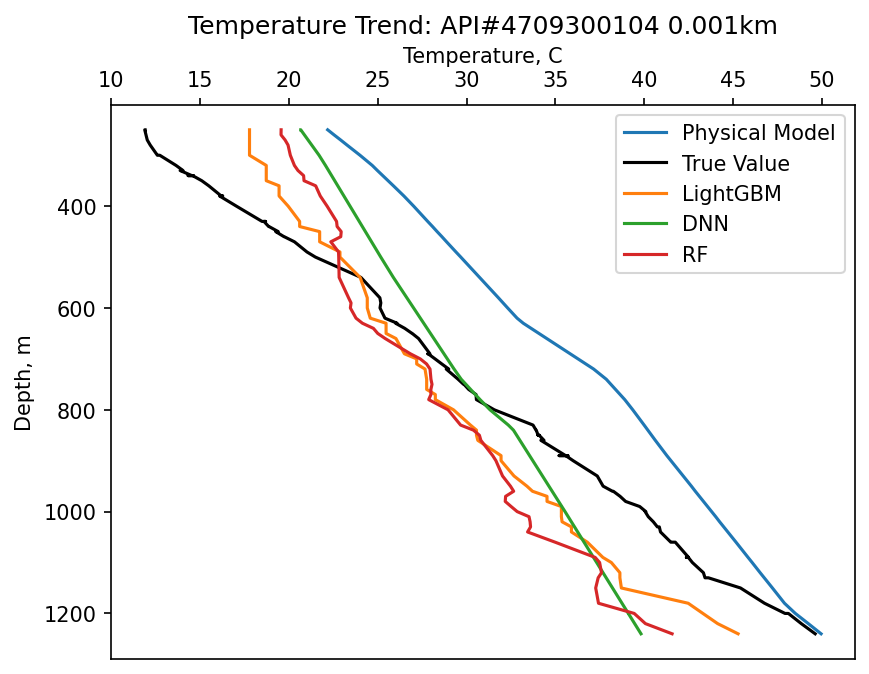

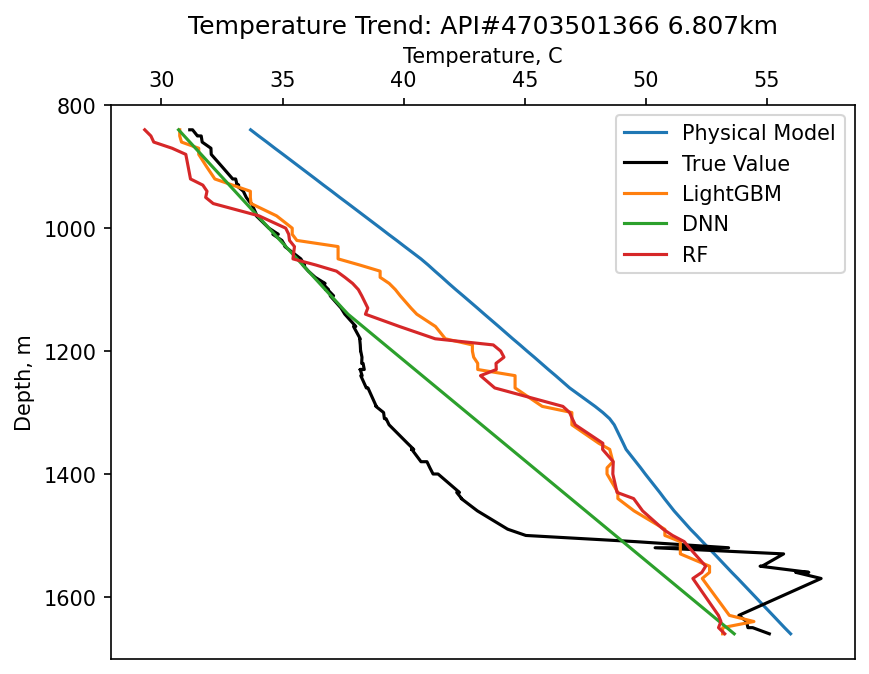

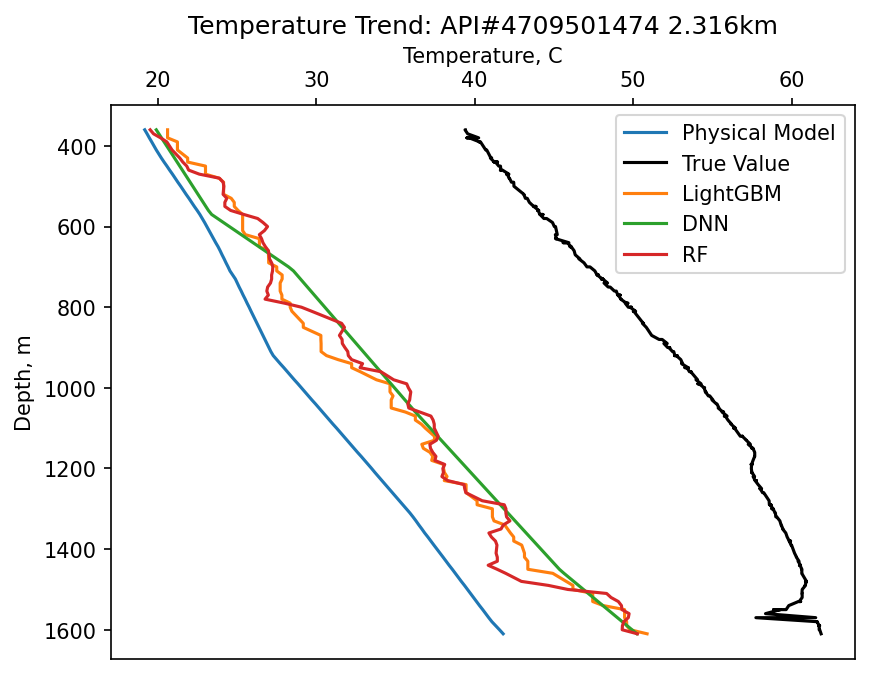

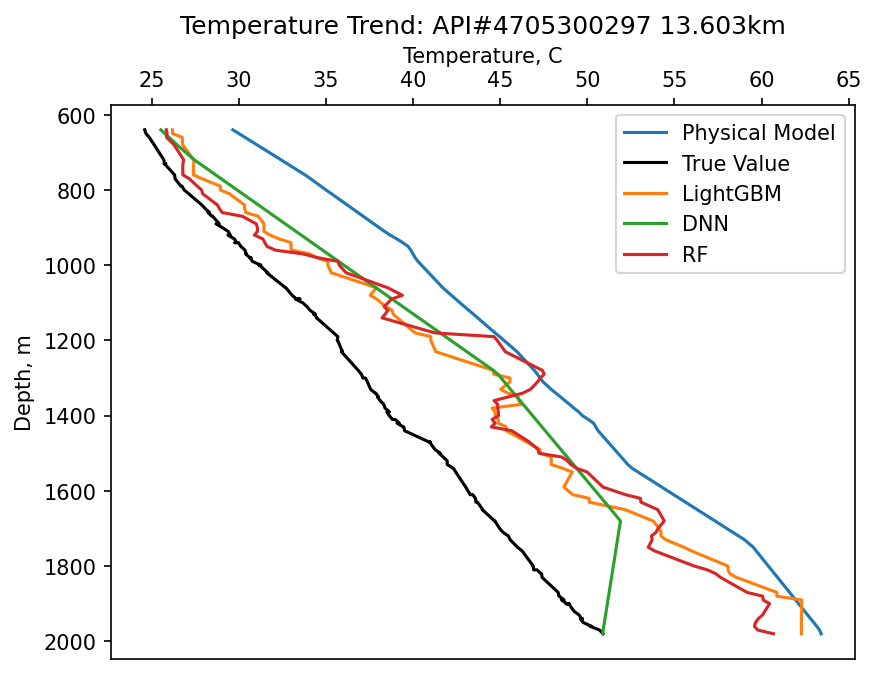

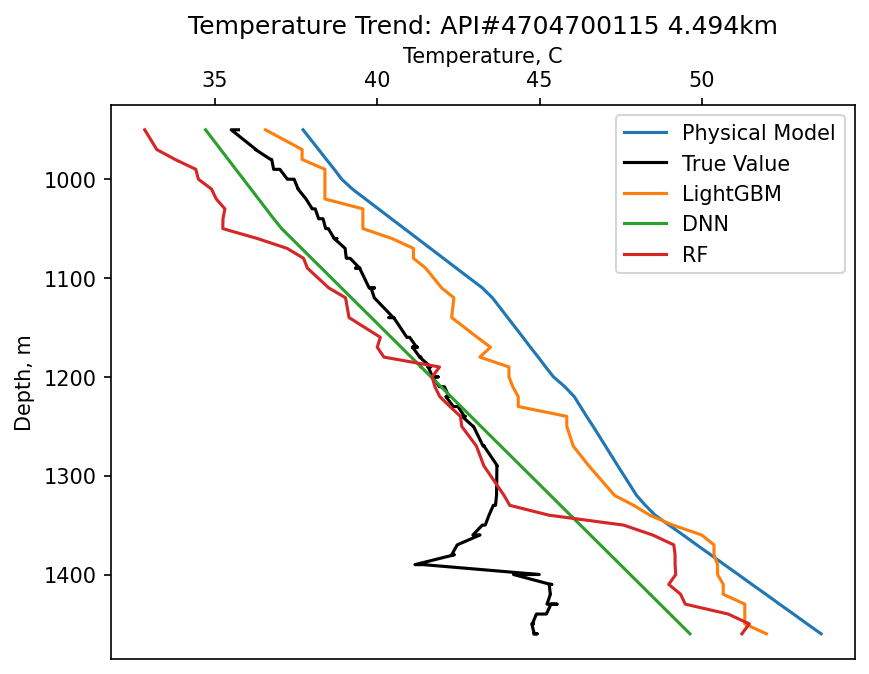

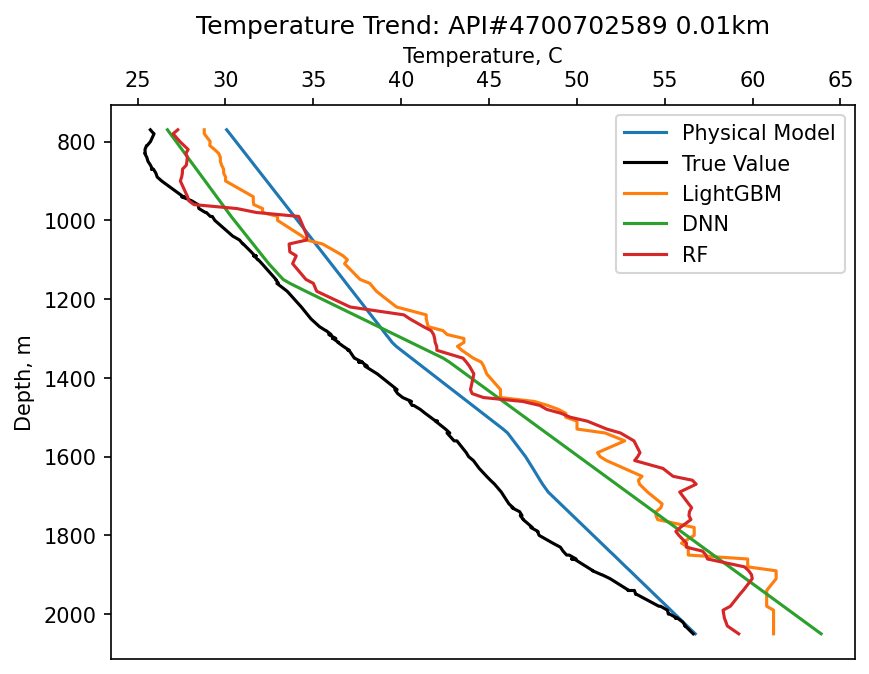

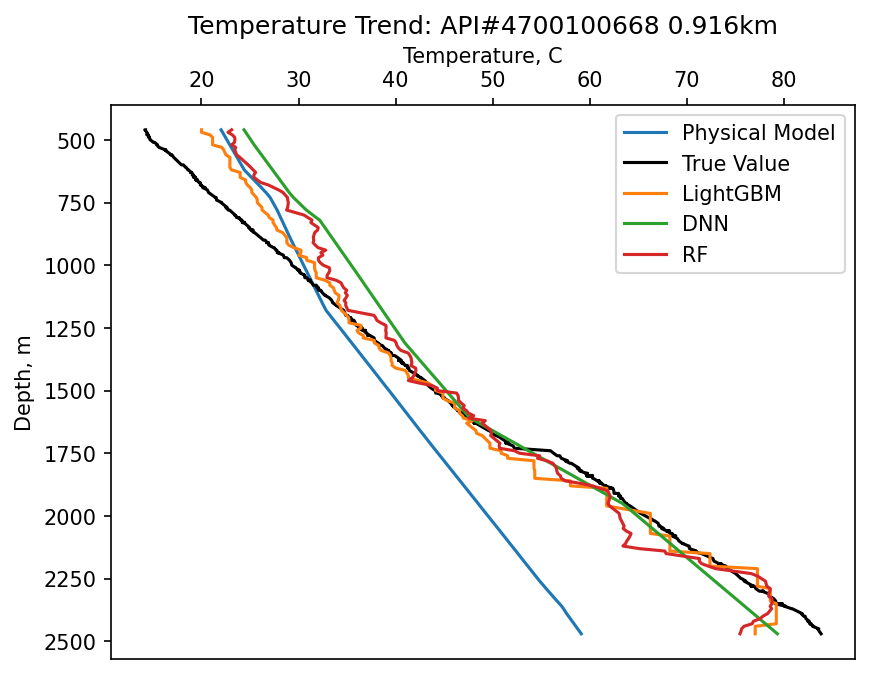

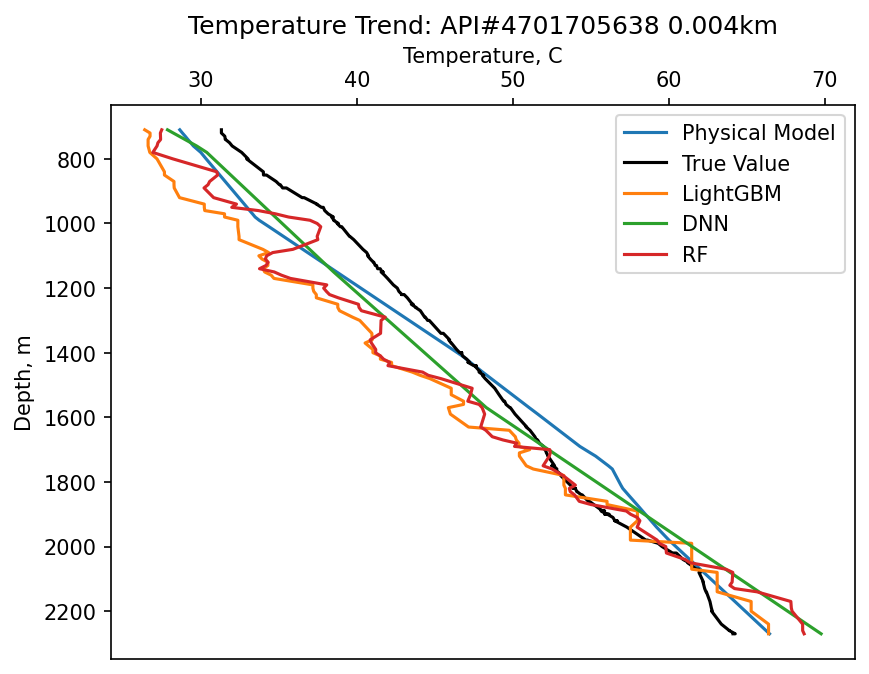

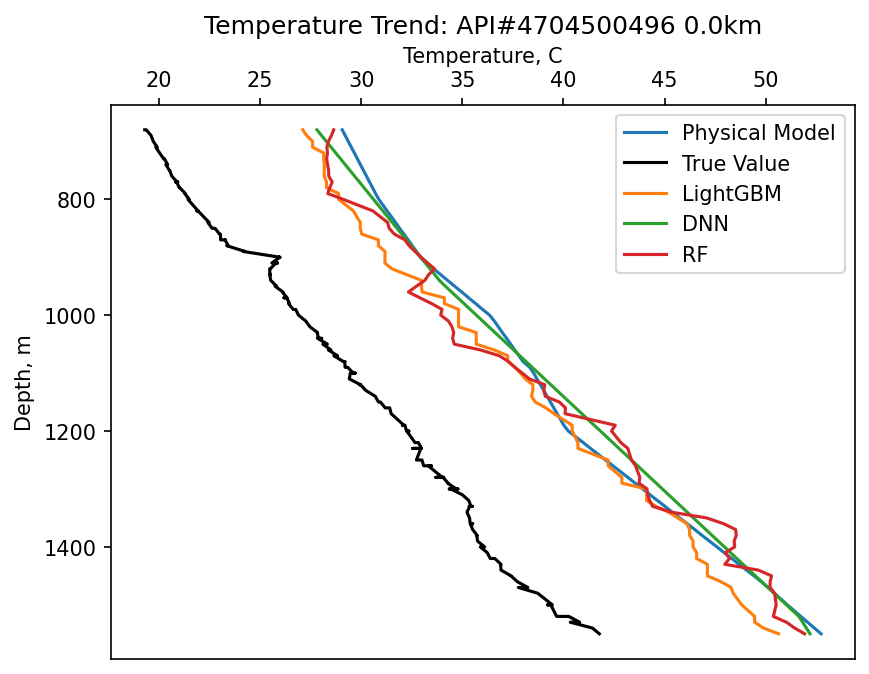

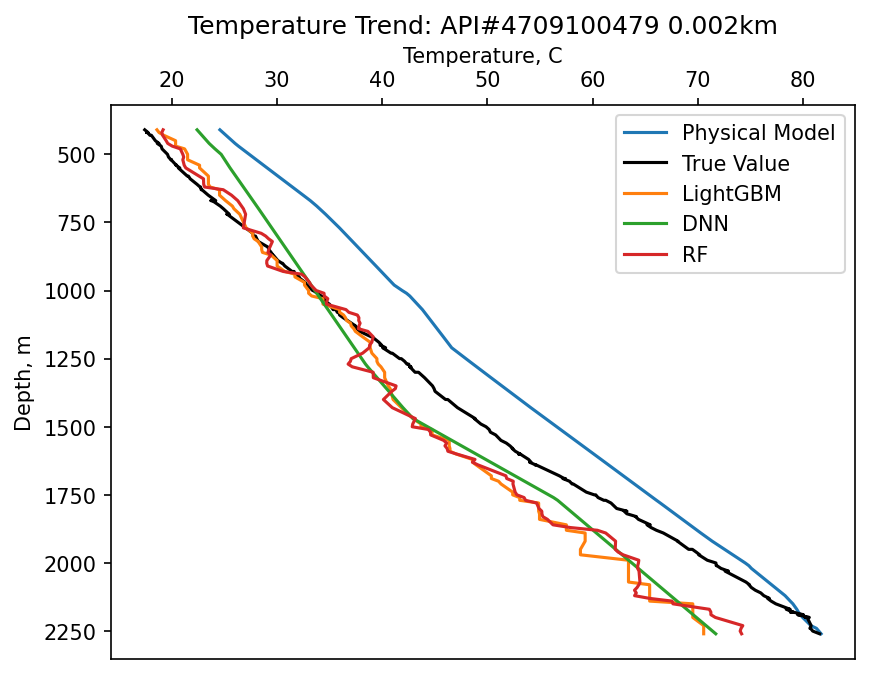

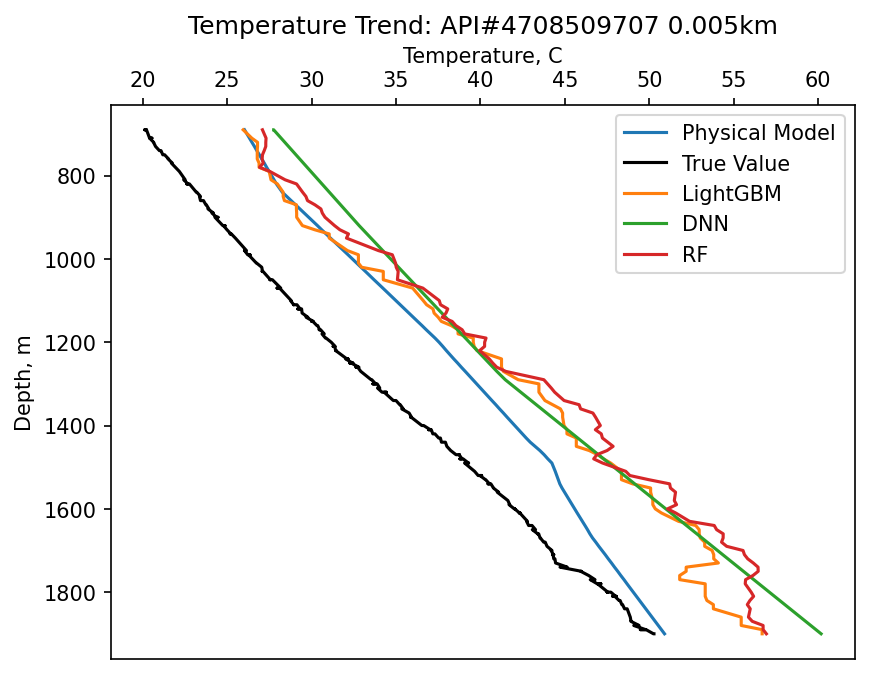

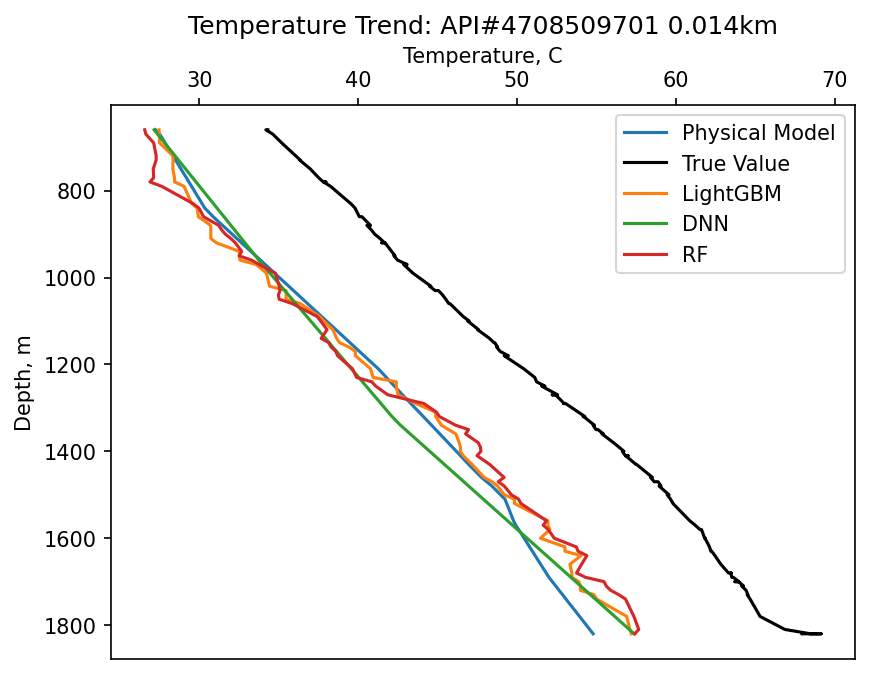

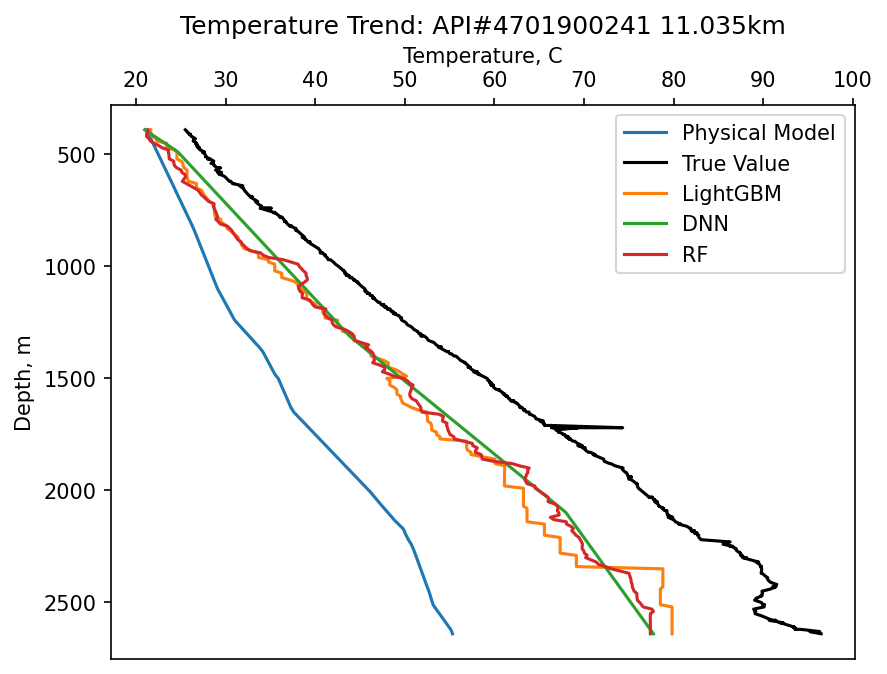

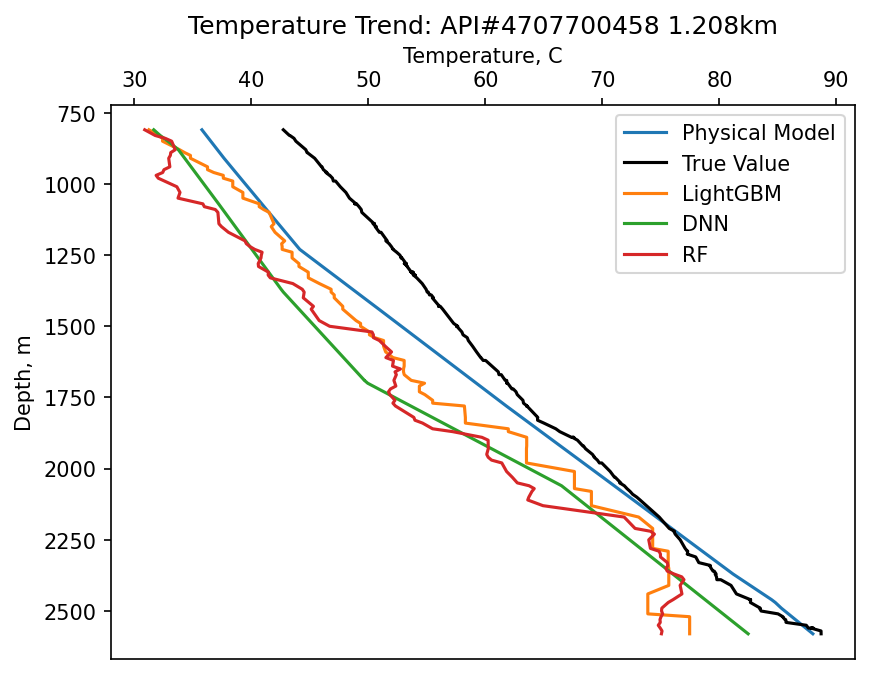

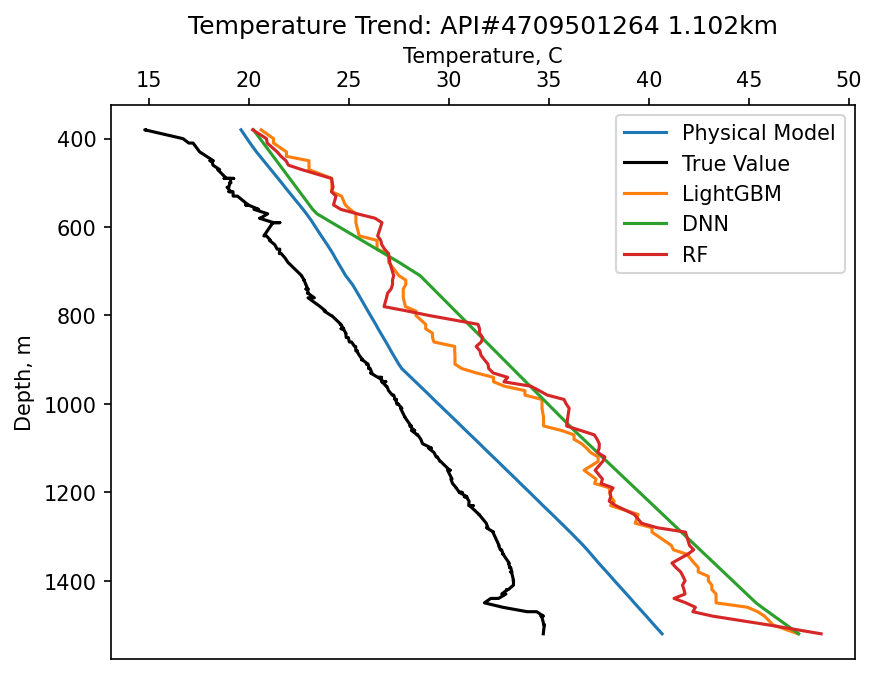

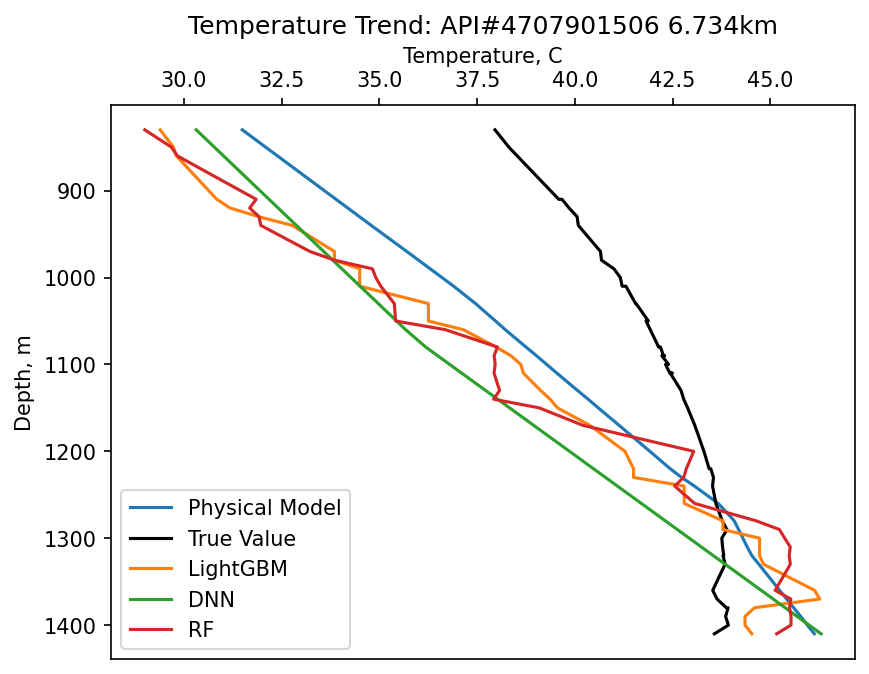

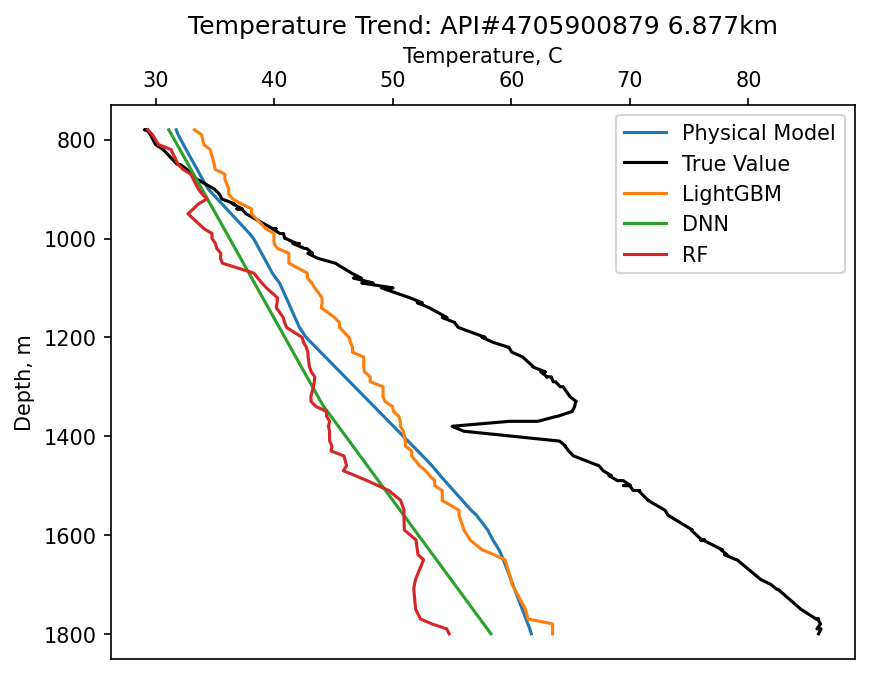

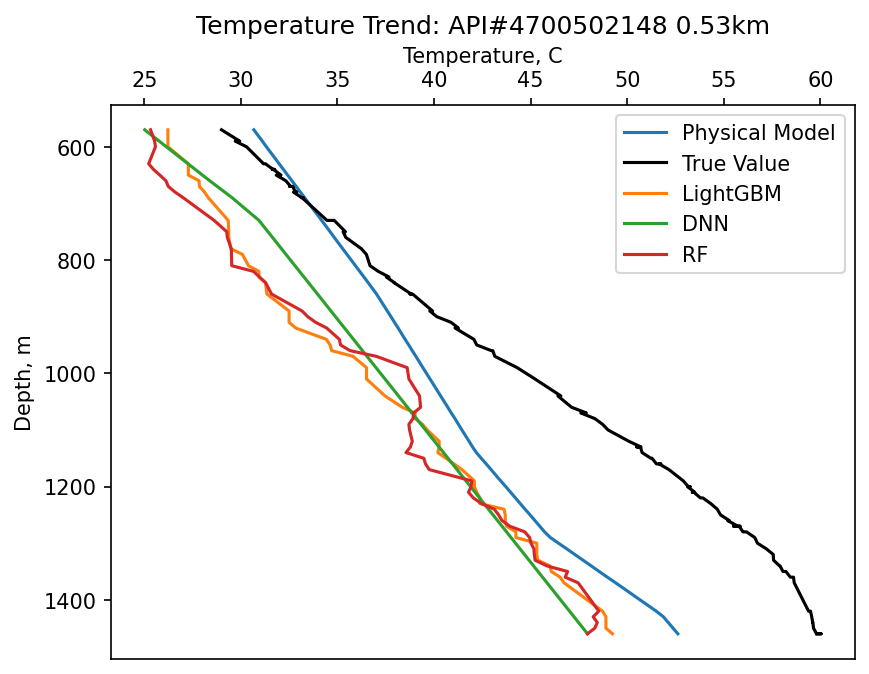

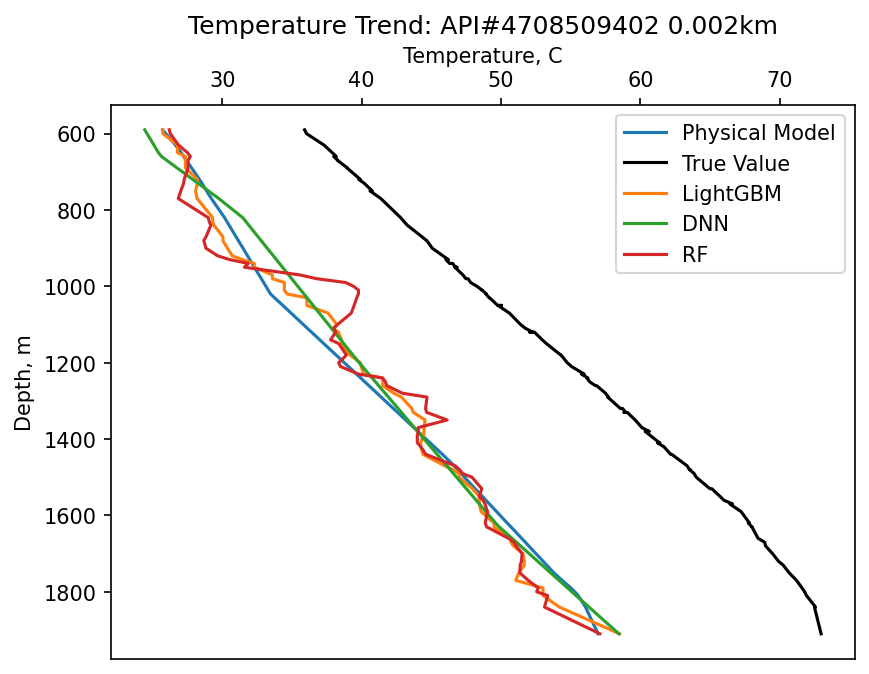

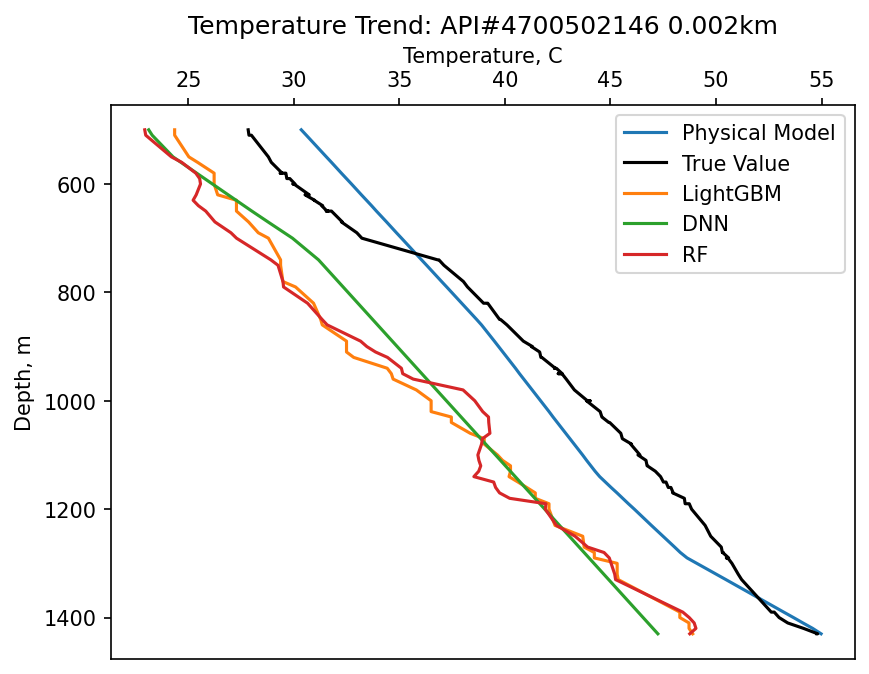

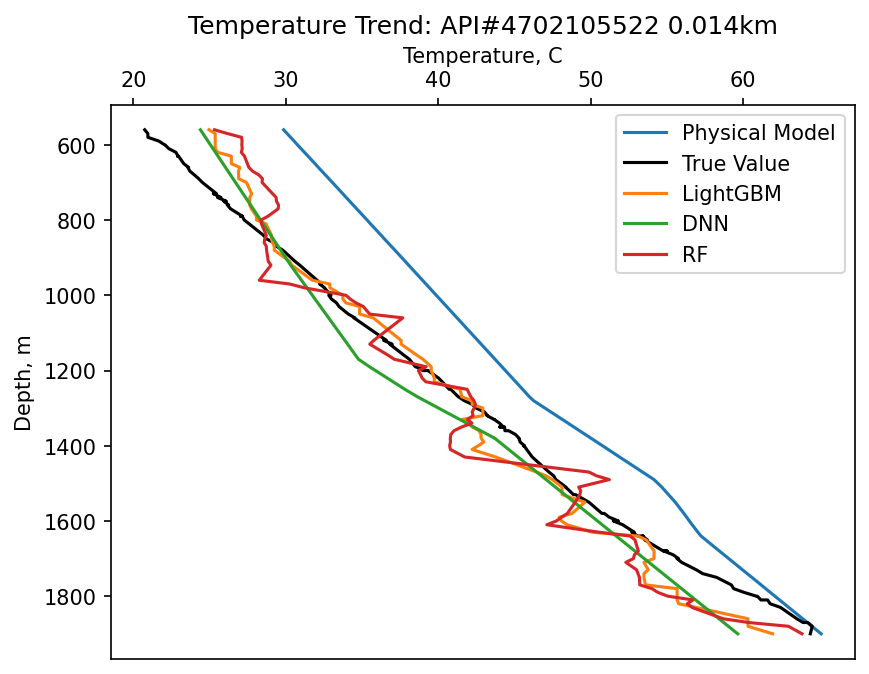

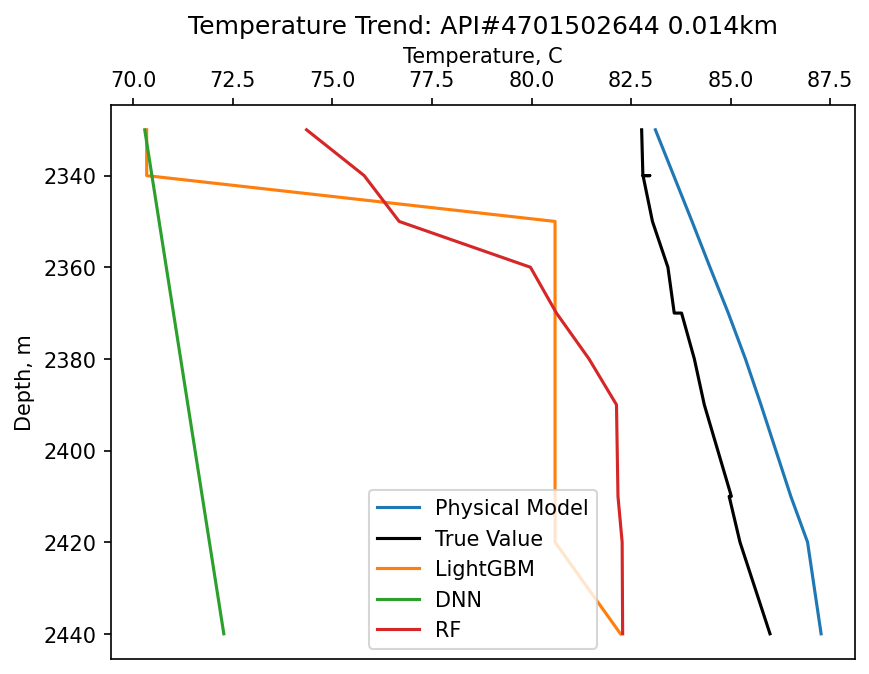

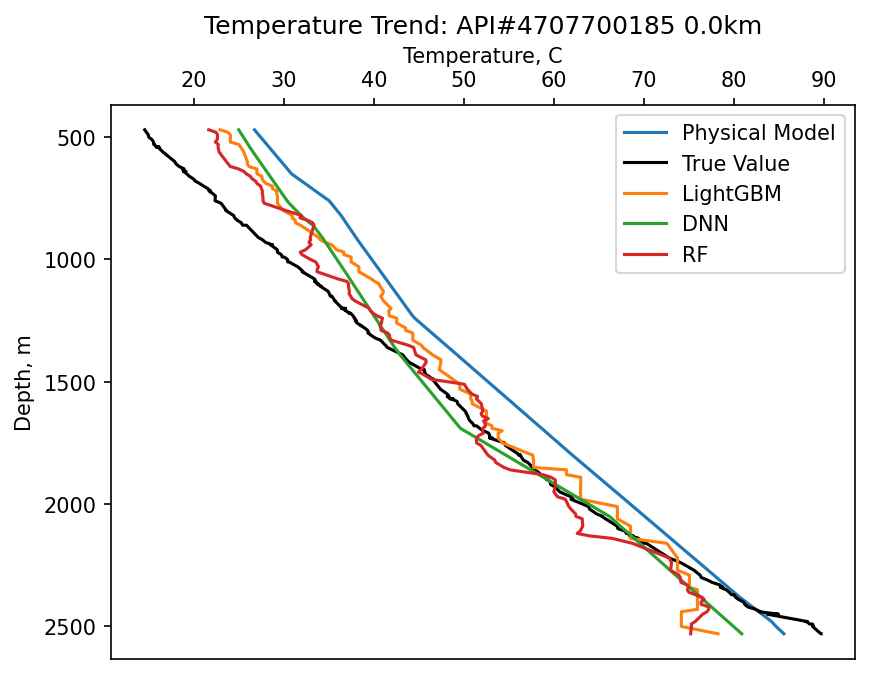

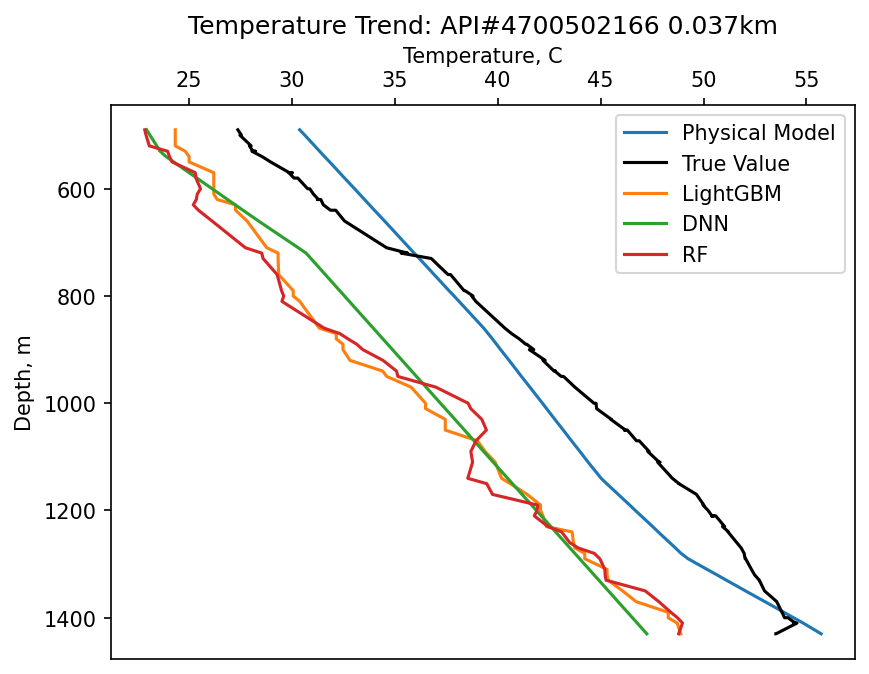

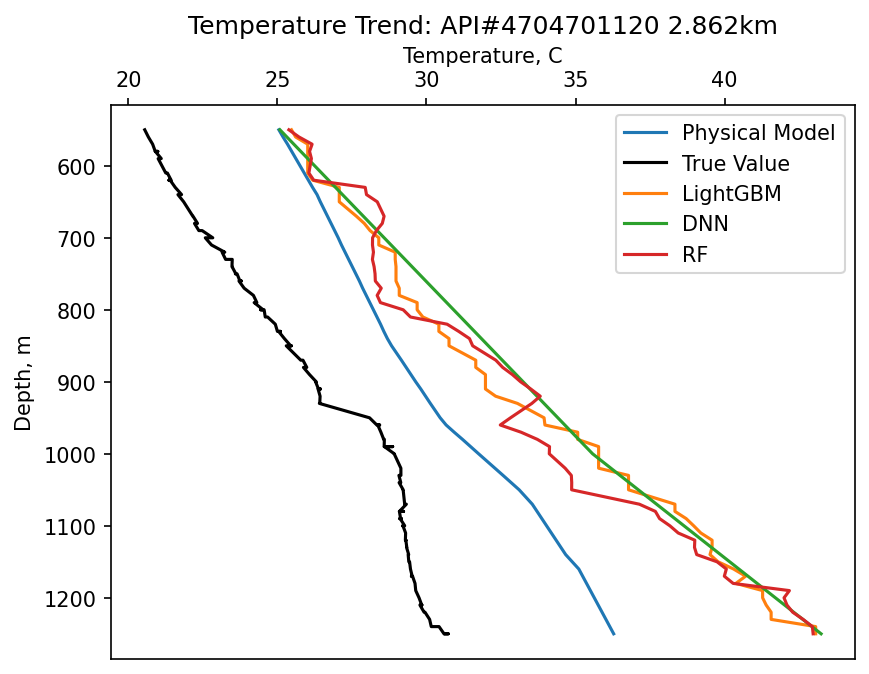

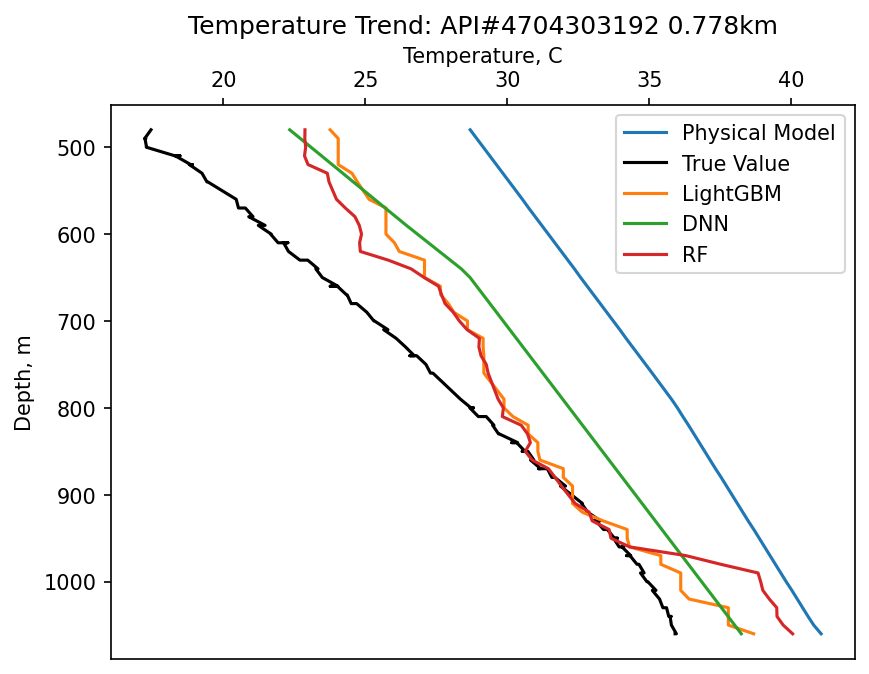

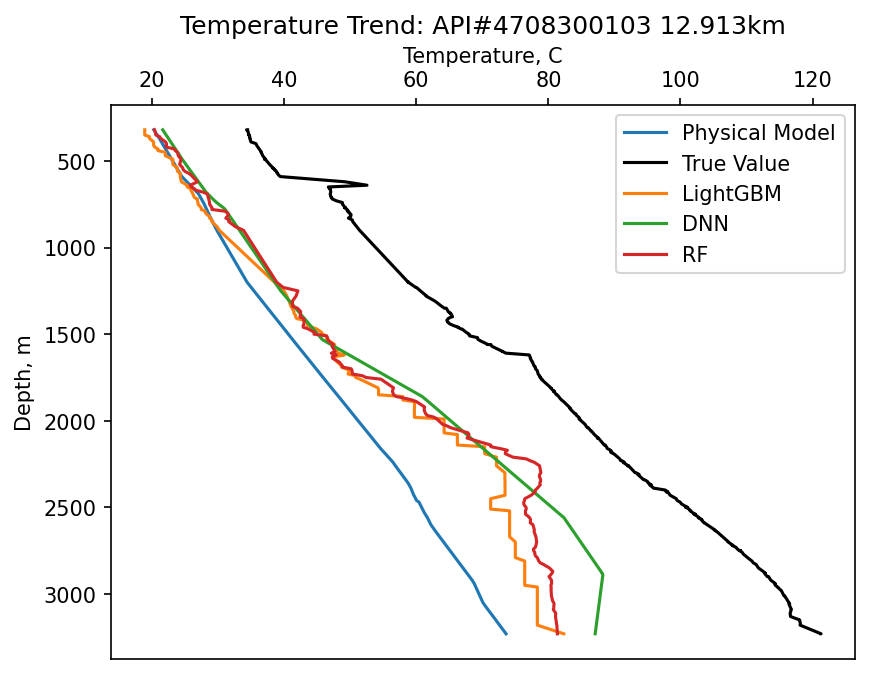

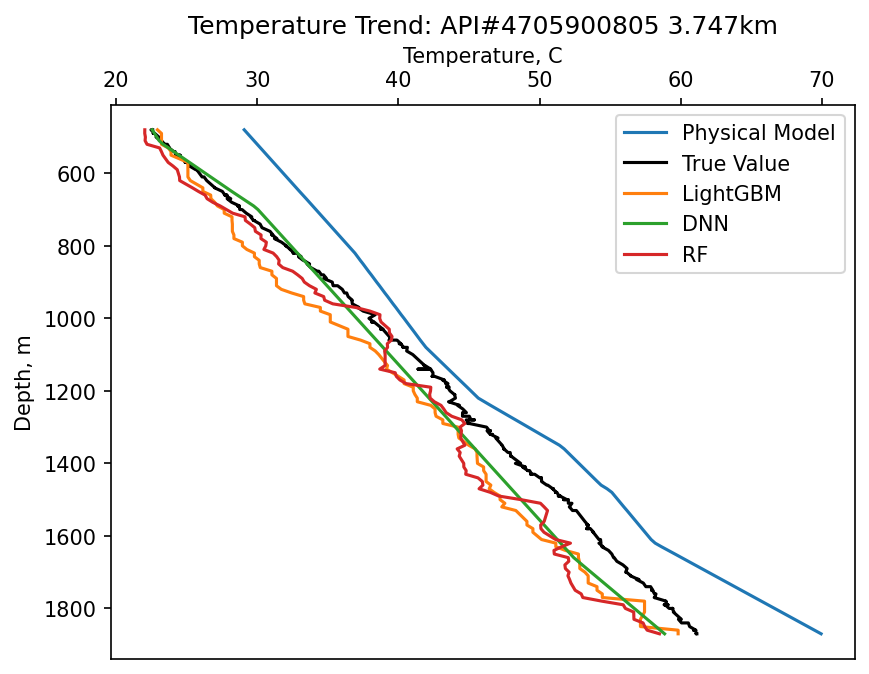

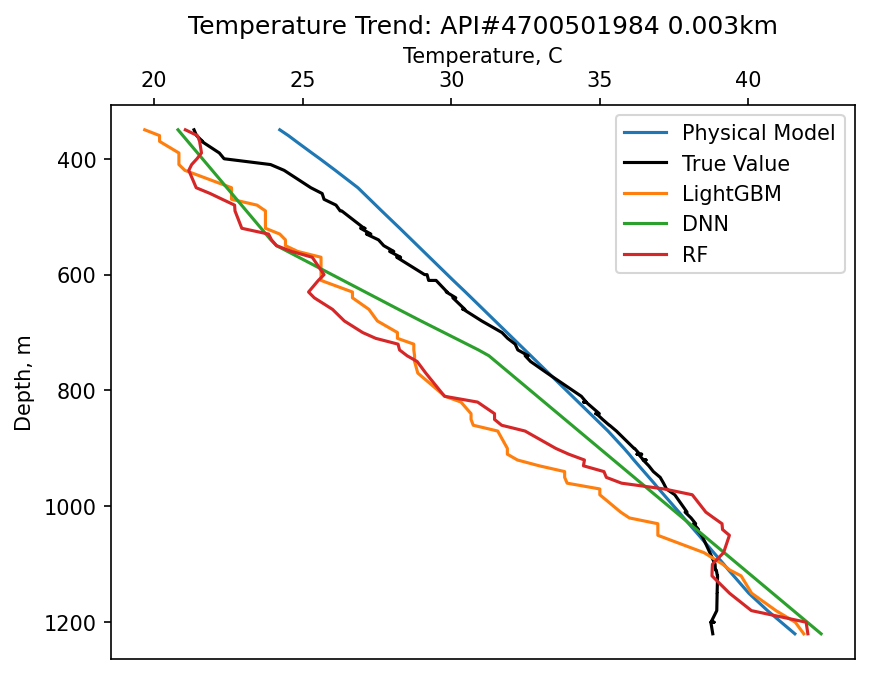

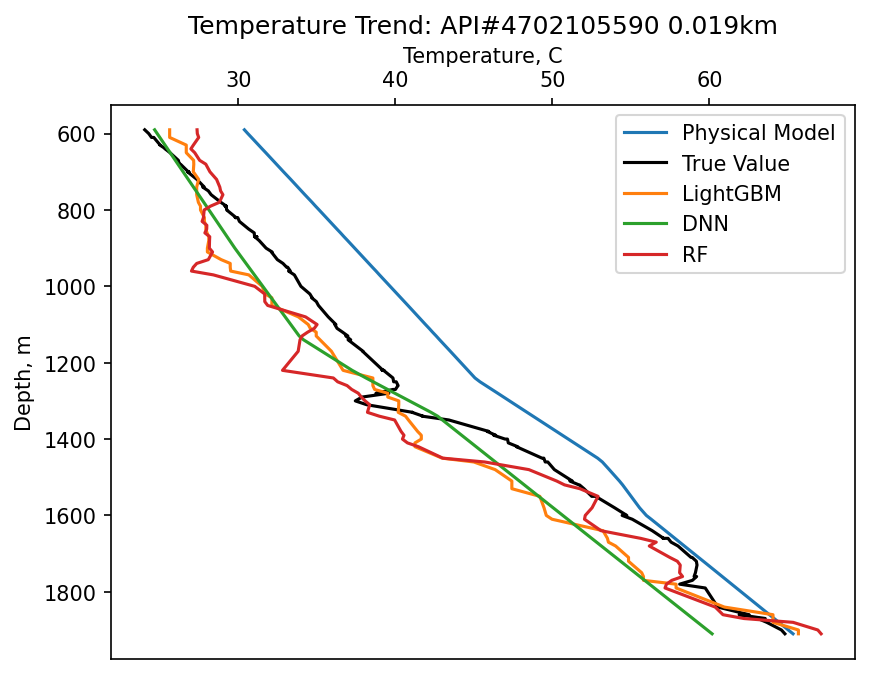

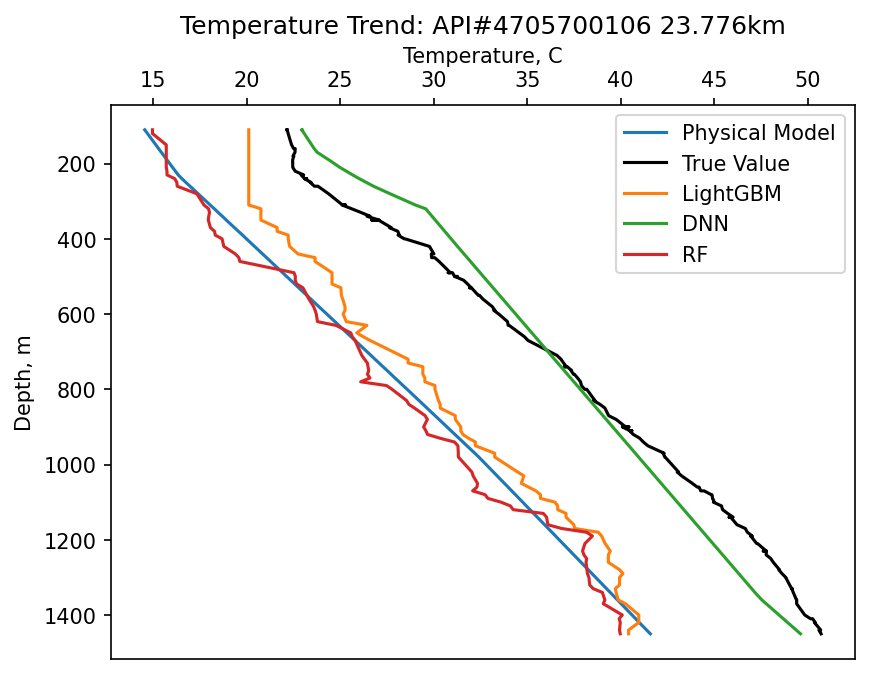

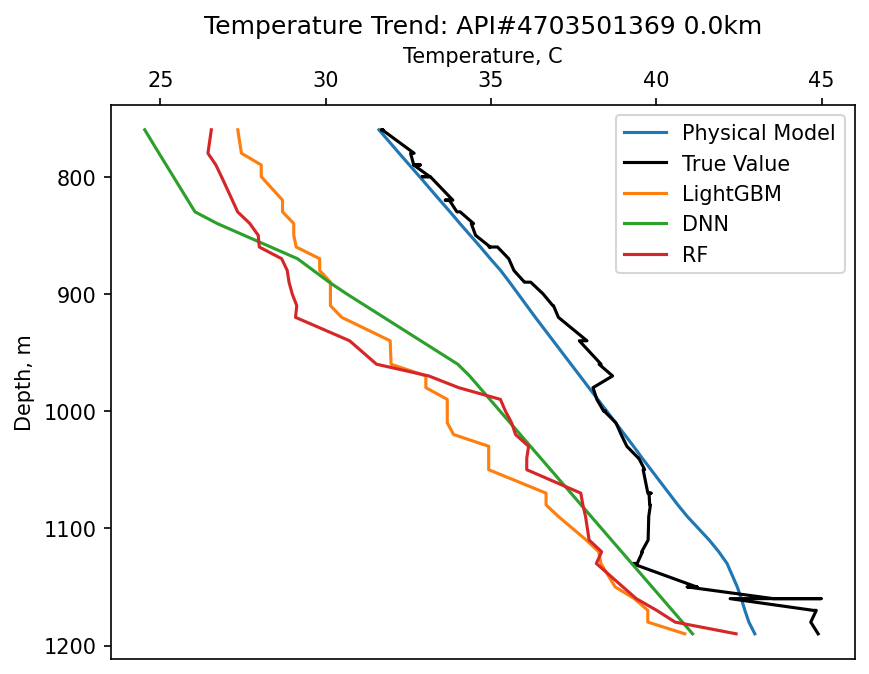

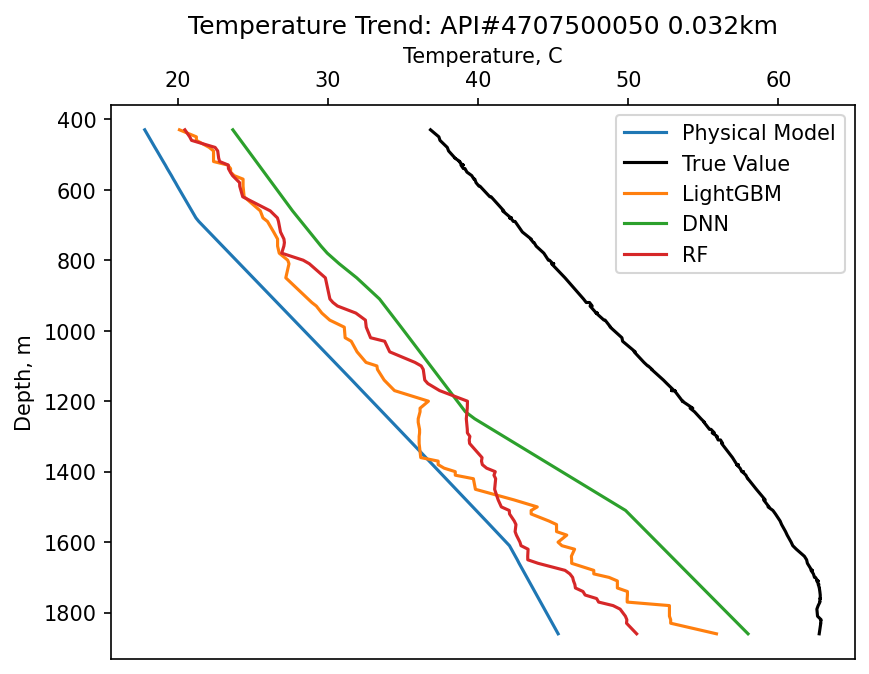

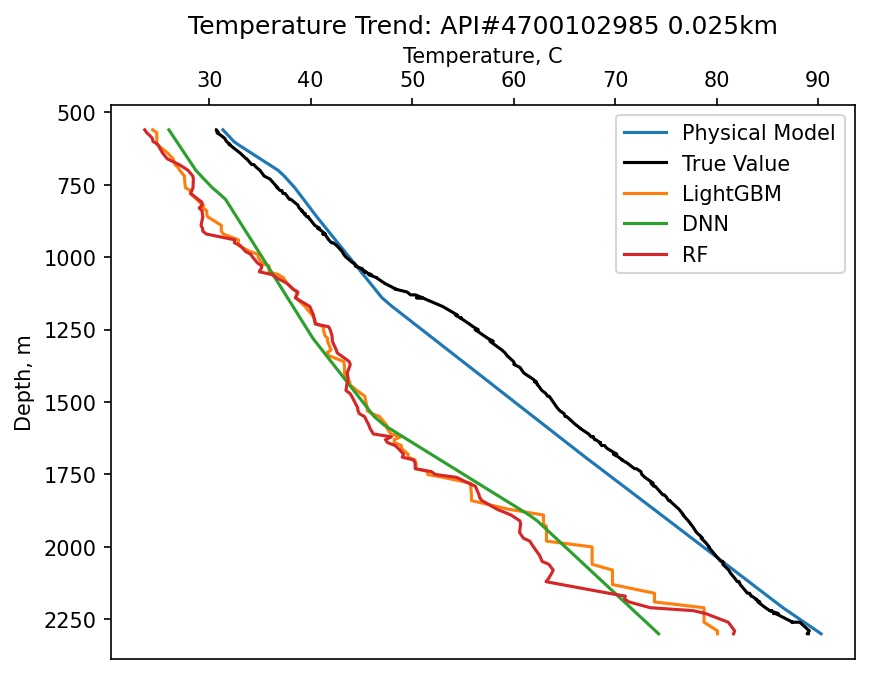

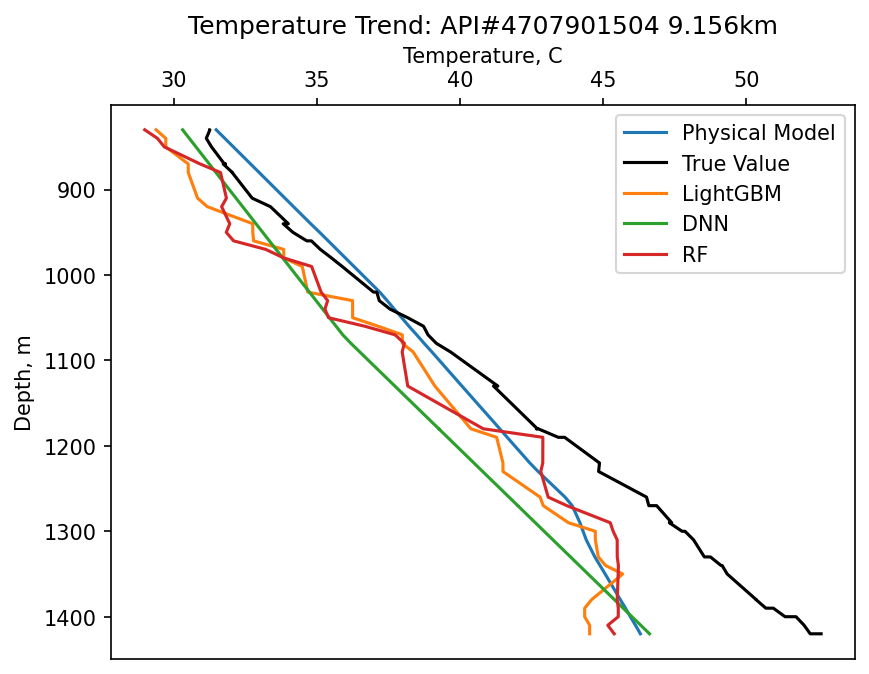

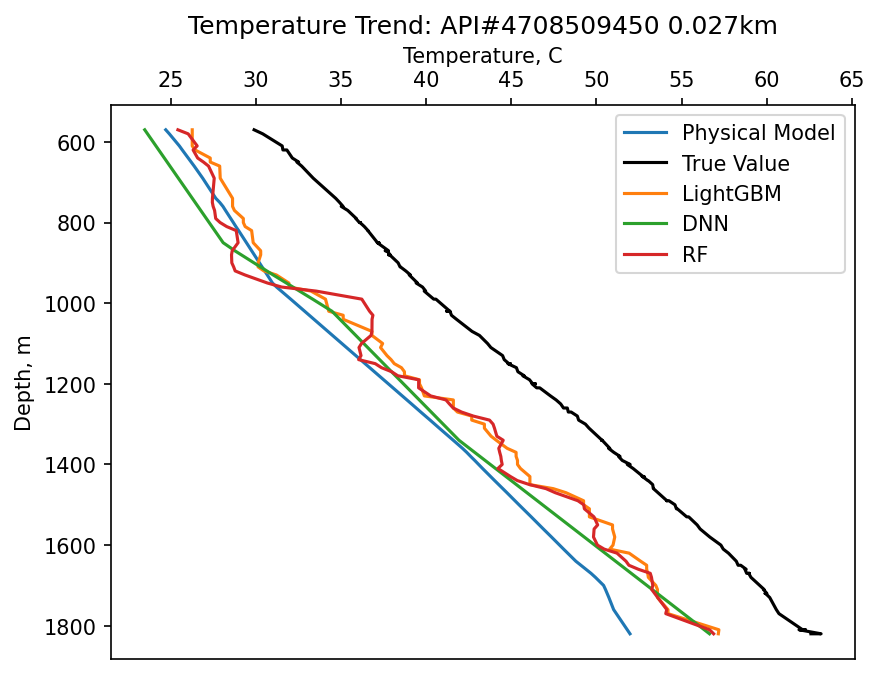

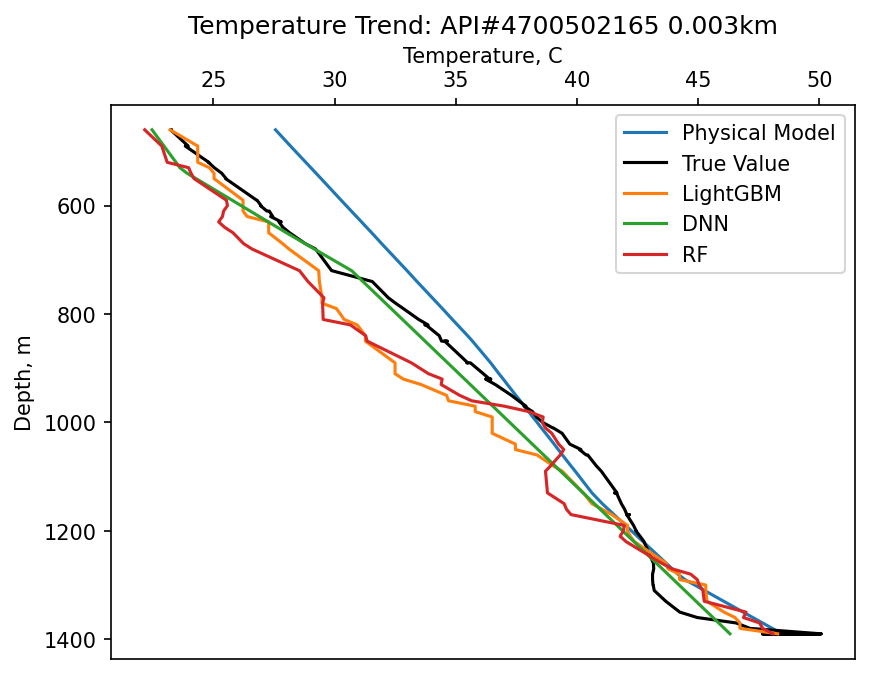

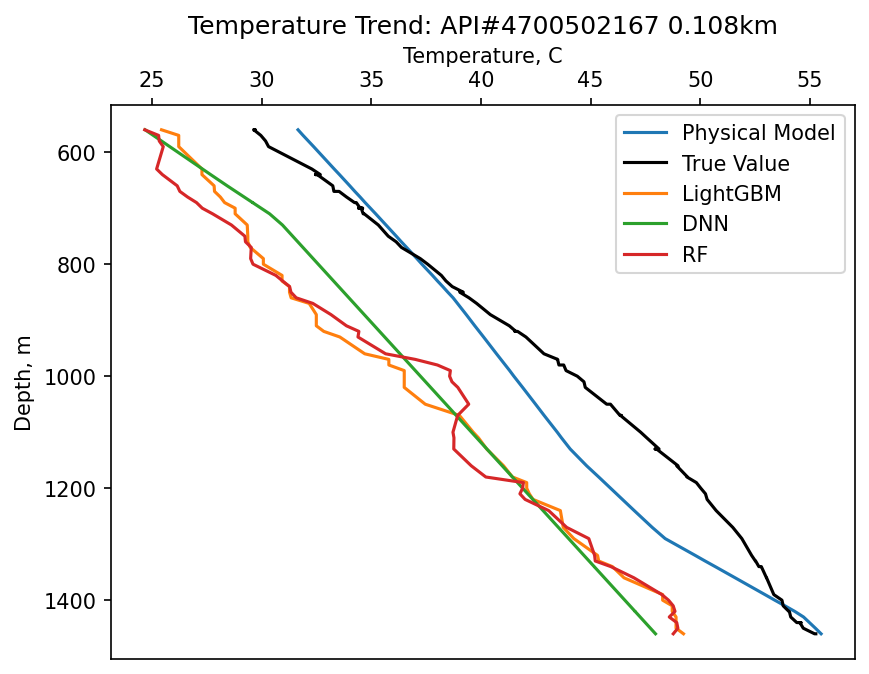

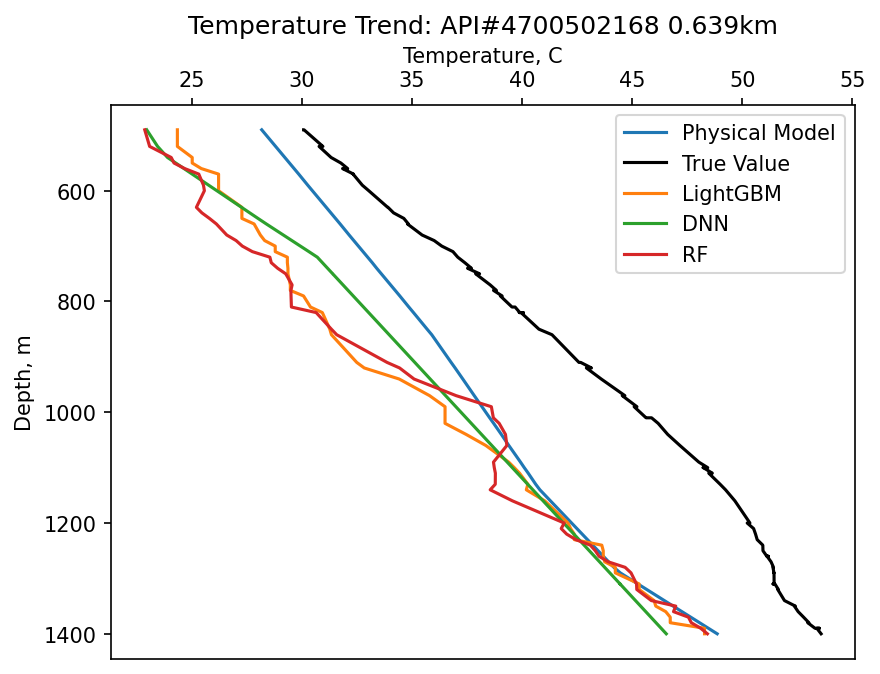

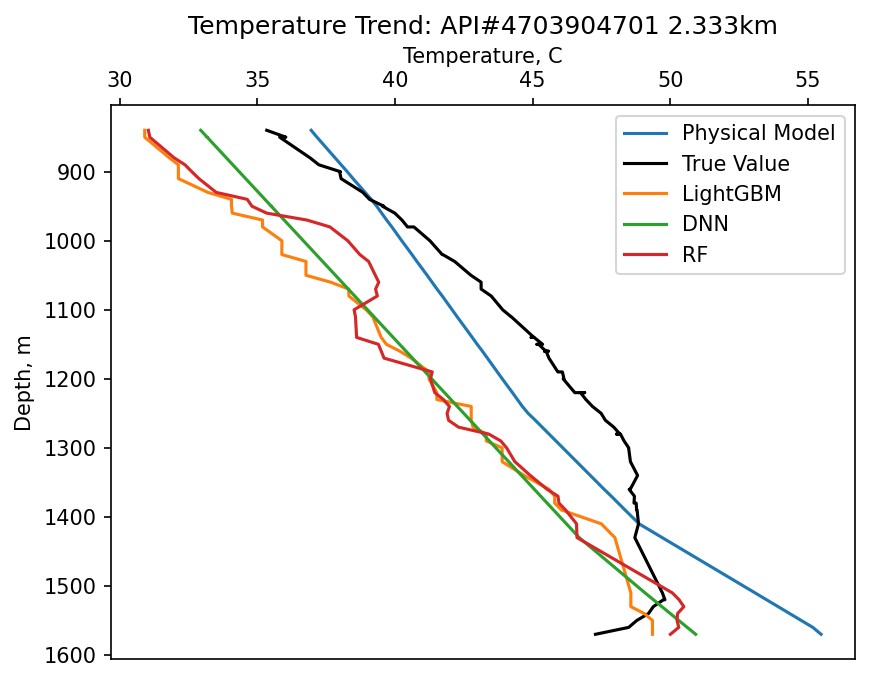

In [203]:
for i in unique:
    well = grouped.get_group(i).sort_values(by='depth')
    plt.plot(well['physics_pred'], well['depth'])
    plt.plot(well['corrtemp'], well['depth'], color='black')
    plt.plot(well['LightGBM_pred'], well['depth'])
    plt.plot(well['dnn_pred'], well['depth'])
    plt.plot(well['RF_pred'], well['depth'])
    plt.legend(['Physical Model', 'True Value', 'LightGBM', 'DNN', 'RF'])
    plt.ylabel('Depth, m')
    plt.gca().invert_yaxis()
    plt.gca().xaxis.set_ticks_position('top')
    plt.xlabel('Temperature, C')
    plt.gca().xaxis.set_label_position('top')
    curr_dist = sampled_df2[sampled_df2.id==i].distance.values[0]
    plt.title('Temperature Trend: API#'+str(i) + ' '+str(round(curr_dist,3)) + 'km')
    plt.show()

In [204]:
grouped.get_group(unique[0])

index          id  depth       temp        lat        lon    corrtemp  \
0     509169  4702500022   2940  87.055556  38.060082 -80.733279  104.219611   
17    504420  4702500022   2580  75.577778  38.060082 -80.733279   90.382416   
89    507375  4702500022   2800  79.466667  38.060082 -80.733279   95.739420   
186   505882  4702500022   2690  77.600000  38.060082 -80.733279   93.130995   
231   510934  4702500022   3070  91.300000  38.060082 -80.733279  109.340950   
...      ...         ...    ...        ...        ...        ...         ...   
9431  507917  4702500022   2840  81.661111  38.060082 -80.733279   98.203143   
9657  508145  4702500022   2860  82.638889  38.060082 -80.733279   99.294197   
9725  508431  4702500022   2880  84.066667  38.060082 -80.733279  100.864066   
9821  508683  4702500022   2900  85.061111  38.060082 -80.733279  101.983710   
9846  509402  4702500022   2960  88.138889  38.060082 -80.733279  105.418705   

      closest  physics_pred  LightGBM_pred   dnn_pred    RF_pred   distance  \
0       18080         69.19      84.523753  67.925041  82.276049  11.637734   
17      18080         63.40      79.076452  69.154472  76.734417  11.637734   
89      18080         66.91      84.523753  68.403168  77.046656  11.637734   
186     18080         65.02      79.076452  68.778809  76.772968  11.637734   
231     18080         71.04      84.937745  69.214073  82.672235  11.637734   
...       ...           ...            ...        ...        ...        ...   
9431    18080         67.70      84.523753  68.266571  80.775771  11.637734   
9657    18080         68.10      84.523753  68.198288  81.303140  11.637734   
9725    18080         68.44      84.523753  68.129929  81.802084  11.637734   
9821    18080         68.66      84.523753  68.061646  81.686554  11.637734   
9846    18080         69.47      84.937745  68.046707  82.307312  11.637734   

      avgd_model  
0      73.879598  
17     70.543641  
89     73.278974  
186    70.958420  
231    75.063939  
...          ...  
9431   73.496775  
9657   73.607347  
9725   73.697894  
9821   73.748466  
9846   74.151484  

[135 rows x 14 columns]

In [205]:
grouped.get_group(unique[0])

index          id  depth       temp        lat        lon    corrtemp  \
0     509169  4702500022   2940  87.055556  38.060082 -80.733279  104.219611   
17    504420  4702500022   2580  75.577778  38.060082 -80.733279   90.382416   
89    507375  4702500022   2800  79.466667  38.060082 -80.733279   95.739420   
186   505882  4702500022   2690  77.600000  38.060082 -80.733279   93.130995   
231   510934  4702500022   3070  91.300000  38.060082 -80.733279  109.340950   
...      ...         ...    ...        ...        ...        ...         ...   
9431  507917  4702500022   2840  81.661111  38.060082 -80.733279   98.203143   
9657  508145  4702500022   2860  82.638889  38.060082 -80.733279   99.294197   
9725  508431  4702500022   2880  84.066667  38.060082 -80.733279  100.864066   
9821  508683  4702500022   2900  85.061111  38.060082 -80.733279  101.983710   
9846  509402  4702500022   2960  88.138889  38.060082 -80.733279  105.418705   

      closest  physics_pred  LightGBM_pred   dnn_pred    RF_pred   distance  \
0       18080         69.19      84.523753  67.925041  82.276049  11.637734   
17      18080         63.40      79.076452  69.154472  76.734417  11.637734   
89      18080         66.91      84.523753  68.403168  77.046656  11.637734   
186     18080         65.02      79.076452  68.778809  76.772968  11.637734   
231     18080         71.04      84.937745  69.214073  82.672235  11.637734   
...       ...           ...            ...        ...        ...        ...   
9431    18080         67.70      84.523753  68.266571  80.775771  11.637734   
9657    18080         68.10      84.523753  68.198288  81.303140  11.637734   
9725    18080         68.44      84.523753  68.129929  81.802084  11.637734   
9821    18080         68.66      84.523753  68.061646  81.686554  11.637734   
9846    18080         69.47      84.937745  68.046707  82.307312  11.637734   

      avgd_model  
0      73.879598  
17     70.543641  
89     73.278974  
186    70.958420  
231    75.063939  
...          ...  
9431   73.496775  
9657   73.607347  
9725   73.697894  
9821   73.748466  
9846   74.151484  

[135 rows x 14 columns]